## Melbourne Cafe/Restaurant Recommender System

The Data:
- Source: Zomato
- URL: https://www.zomato.com/melbourne/great-food-no-bull
- Best of Melbourne Collection
- Retrieved 253 restaurants, 30475 reviews

The Tools/Techniques/Libraries:
- Surprise, Scipy, Web Scraping, Selenium, Scrapy, XPath, Zomato API, Google Maps API, Geopy

The Techniques:
- Content-Based Filtering
- User-Item Collaborative Filtering (pairwise-cosine distance)
- Item-Item Collaborative Filtering (pairwise-cosine distance)
- Item-Item Collaborative Filtering - Top-N Recommendation and Rating Prediction (pairwise-cosine distance)
- Item-Item Collaborative Filtering - Top-N Recommendation and Rating Prediction (pairwise-cosine Similarity)
- Hybrid Recommender - User-Item CF & Content-Based
- Hybrid Recommender - Item-Item CF & Content-Based
- Rating Prediction and Evaluation for Entire Matrices using Memory-Based CF 
- Rating Prediction and Evaluation for Entire Matrices using Model-Based CF - Scipy SVDS (Matrix Factorization)
- Rating Prediction and Evaluation for Individual User-Restaurant Pair using - Surprise SVD (Matrix Factorization)
- Recent Favorites Recommendation
- Most Popular Recommendation

The Goal:
- Provide top-n restaurant recommendations to users
- Predict the rating that a user would give an unrated restaurant
- Evaluate the rating prediction

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from math import sqrt

import scipy.sparse as sp
from scipy.sparse.linalg import svds

from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import googlemaps

import datetime
from datetime import date
from time import sleep

from scrapy.selector import Selector
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import requests
import re

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

### Scrape business profiles

In [ ]:
# get the url's of the businesses featured in 'best of Melbourne' collection 
def get_business_urls(html):
    
    # restaurant url's
    try:
        url_list=Selector(text=html).xpath('//div[@class="row col-res-list collection_listings_container"]/div/div/div/a/@href').extract()
    except:
        url_list=np.NaN
        return np.NaN
    
    print(url_list)
    return url_list

In [ ]:
# get the reviews for a specific business
def get_reviews_per_url(html):

    reviews_per_business = []
    review_index = 0
    
    # get restaurant id and review id (separately, as these two are outside the xpath scope defined below)
    # review id list 
    try:
        review_id_list = Selector(text=html).xpath('//div[@id="reviews-container"]/*//div[@data-snippet="restaurant-review"]/@data-review_id').extract()
        print('# of review ids: ',len(review_id_list))
    except:
        review_id_list= np.NaN
        print('error on review id list for : ', review_id_list)
        
    # restaurant id
    try:
        restaurant_id = Selector(text=html).xpath('//div[@id="reviews-container"]/*//div[@data-snippet="restaurant-review"]/@data-res_id').extract()[0]
    except:
        restaurant_id = np.NaN
        print('error on restaurant_id for : ', restaurant_id)
        
    # get data for displayed reviews 
    visible_reviews_full = Selector(text=html).xpath('//div[@id="reviews-container"]/*//div[@data-snippet="restaurant-review"]/div[contains(@class,"ui segment")]').extract()
    num_reviews=len(visible_reviews_full)

    # iterate through the displayed reviews
    for review in visible_reviews_full:

        # review id
        try:
            review_id= review_id_list[review_index]
        except:
            print('error on iterating through review id for: ', review_id_list)
            
        # user id
        try:
            user_id=Selector(text=review).xpath('//div[contains(@class,"content col-l-11")]/*/a[contains(@href,"https://www.zomato.com")]/@data-entity_id').extract()[0]
        except:
            user_id=np.NaN

        # user name
        try:
            user_name=Selector(text=review).xpath('//div[contains(@class,"content col-l-11")]/*/a[contains(@href,"https://www.zomato.com")]/text()').extract()[0].strip()
        except:
            user_name=np.NaN

        # no. of reviews by user
        try:
            user_review_count=Selector(text=review).xpath('//div[contains(@class,"content col-l-11")]/span[contains(@class,"grey-text")]/text()').extract()[0].strip().split(',')[0].strip().split(' ')[0]
        except:
            user_review_count=np.NaN

        # no. of followers of user
        try:
            user_followers_count=Selector(text=review).xpath('//div[contains(@class,"content col-l-11")]/span[contains(@class,"grey-text")]/text()').extract()[0].strip().split(',')[1].strip().split(' ')[0]
        except:
            user_followers_count=np.NaN

        # review date
        try:
            review_date=Selector(text=review).xpath('//time/@datetime').extract()[0]
        except:
            review_date=np.NaN

        # star rating
        try:
            star_rating=Selector(text=review).xpath('//div[contains(@class,"rev-text")]/div[contains(@class,"ttupper fs12px")]/@aria-label').extract()[0].split(' ')[1]
        except:
            star_rating=np.NaN

        # textual review
        try:
            textual_review=Selector(text=review).xpath('//div[contains(@class,"rev-text ")]/text()').extract()[1:]
        except:
            textual_review=np.NaN

        # clean textual review, convert to string
        try:
            textual_review[0] = textual_review[0].replace('\xa0\n', '').strip()
            textual_review = ''.join([line.strip() for line in textual_review if line.strip() is not ''])
        except:
            print('error in cleaning textual_review for : ', textual_review)
            
        # append scraped review to list
        reviews_per_business.append([review_id, restaurant_id, user_id, user_name, user_review_count, user_followers_count, review_date, star_rating, textual_review])
        review_index += 1
        
    return reviews_per_business, num_reviews

In [ ]:
# start of code for getting the business url's in the 'best of Melbourne' collection

# open business reviews url
main_url = 'https://www.zomato.com/melbourne/great-food-no-bull'
driver = webdriver.Chrome(executable_path="chromedriver.exe")
try:
    sleep(5)
    driver.get(main_url)
except:
    print('error in loading driver for business url: ', main_url)        
assert "Zomato" in driver.title

# parse first results page
sleep(5)
# set HTML to the response from the http request
html = driver.page_source

url_list = get_business_urls(html)

driver.close()

In [ ]:
# start of code for getting the reviews for each business featured in 'best of Melbourne' collection

# target count of reviews to extract
review_target_count = 200
all_business_reviews = []
num_reviews_list = []
business_with_zero_reviews = []

monitor_count=0    

total_count=len(url_list)
# iterate through the url's of the businesses to extract the reviews
for business_url in url_list:

    # open business reviews url
    driver = webdriver.Chrome(executable_path="chromedriver.exe")
    try:
        driver.get(business_url + '/reviews')
    except:
        print('error in loading driver for business url: ', business_url)
        
    assert "Zomato" in driver.title

    # if there's a Popular (Reviews) section, change and click on All Reviews section
    driver = switch_from_Popular_to_All_Reviews(driver, business_url + '/reviews')
    
    # display more reviews (in preparation for scraping the target # of reviews)
    driver, visible_review_count = display_more_reviews(driver, review_target_count)

    # get final count of visible reviews (for this particular business)
    html = driver.page_source

    # if review list is not empty
    if visible_review_count > 0:
        # scrape the displayed reviews
        reviews_per_business, num_reviews = get_reviews_per_url(html)

        num_reviews_list.append(num_reviews)
        
        # add reviews per business to overall list of business reviews
        all_business_reviews += reviews_per_business

    # businesses with zero reviews
    else:
        business_with_zero_reviews.append(business_url)

    print('url: ', business_url)    
    monitor_count += 1
    print(str(monitor_count), ' of ', str(total_count), " businesses completed...")

    # save reviews for every 20 businesses to a csv file
    if (monitor_count % 20) == 0:
        reviews_20 = pd.DataFrame(all_business_reviews)
        # save the latest 20 businesses
        reviews_20.to_csv('./datasets/Reviews - Best of Melbourne ' + str(monitor_count-20) + ' to ' + str(monitor_count-1) +  '.csv')
        # clear business reviews list to make way for the next 20 businesses
        all_business_reviews = []
    
    # close the Chrome webdriver
    driver.close()
    
print('business with zero reviews: ', business_with_zero_reviews)
print('number of reviews: ', num_reviews_list)

### Scrape Business Reviews

In [ ]:
# display more reviews by clicking on 'Load More' element
def display_more_reviews(driver, review_target_count):
    
    html = driver.page_source
    
    try:
        # get the visible reviews and review count (for this business)
        visible_reviews = Selector(text=html).xpath('//div[@id="reviews-container"]/*//div[@data-snippet="restaurant-review"]/div[contains(@class,"ui segment")]').extract()    
        visible_review_count = len(visible_reviews)

        # open more reviews by clicking on Load More until the desired # of reviews (for this particular business) is displayed
        while visible_review_count < review_target_count:
            try:
                # access and click on Load More element - to extend the list of displayed reviews
                load_more_element = driver.find_element_by_xpath('//div[@class="load-more bold ttupper tac cursor-pointer fontsize2"]/span[contains(@class,"zred")]')
                load_more_element.click()
                sleep(5)

            except:
                break

            # update the count of visible reviews (for this particular business)
            html = driver.page_source
            visible_reviews = Selector(text=html).xpath('//div[@id="reviews-container"]/*//div[@data-snippet="restaurant-review"]/div[contains(@class,"ui segment")]').extract()
            visible_review_count = len(visible_reviews)
    except:
        print('ERROR IN DISPLAY_MORE_REVIEWS')
    
    return driver, visible_review_count

In [ ]:
# Switch from Popular Reviews to All Reviews, if applicable
def switch_from_Popular_to_All_Reviews(driver, url):
    
    html = driver.page_source
    try:
        # see if Popular Reviews tab exists
        popular_section = Selector(text=html).xpath('//div[@id="selectors"]/a[contains(@data-sort,"reviews-top")]/text()').extract()[0]
        try:
            # access and click on All Reviews element - to switch from Popular Reviews list
            load_more_element = driver.find_element_by_xpath('//div[@id="selectors"]/a[contains(@data-sort,"reviews-dd")]')
            sleep(3)
            load_more_element.click()
            sleep(1)
            print('Popular Reviews section exists for: ' + url)

        except:
            display('All Reviews element not found, or click not successful for:' + url)
    
    except:
        print('No Popular Reviews section for: ' + url)
        
    return driver

In [ ]:
# combine all subset csv's for the 'best of Melbourne' reviews into 1 csv, 'reviews - best of Melbourne.csv'
csv_list = []
reviews_df = pd.DataFrame()

import os
# create list of all review csv's
for file in os.listdir():
    if file.startswith("Reviews - Best of Melbourne"):
        csv_list.append(file)

# load csv's on to a dataframe
for csv in csv_list:
    reviews_df_per_csv = pd.read_csv(csv)
    reviews_df = pd.concat([reviews_df, reviews_df_per_csv])

# save entire dataframe to a single csv for backup
reviews_df.columns=['per_csv_id','review_id', 'restaurant_id', 'user_id', 'user_name', 'user_review_count', 'user_followers_count', 'review_date', 'star_rating', 'textual_review']
reviews_df.to_csv('./datasets/reviews - best of Melbourne.csv')
reviews_df.head()

In [ ]:
# Extract restaurant details through Zomato API 
# This has to be done via Zomato API to include the latitude/longitude details of the businesses in 'best of Melbourne' collection

api_key = <api-key-here>

import pickle
import requests
import pandas as pd
import json
from time import sleep

# using restaurant id's in the extracted reviews, retrieve the restaurant details via Zomato API
def extract_businesses_details(restaurant_id_list):
    
    # set headers
    headers = {
        'Accept': 'application/json',
        'user-key': api_key
    }

    businesses_details_df = pd.DataFrame()
    
    # for every restaurant_id in the Zomato businesses dataset
    for restaurant_id in restaurant_id_list:
        response = requests.get('https://developers.zomato.com/api/v2.1/restaurant?res_id=' + str(restaurant_id), headers=headers)
        response_df = pd.DataFrame([response.json()])
        businesses_details_df = pd.concat([businesses_details_df,response_df], ignore_index=True)

    # pickle dataset
    save_pickle = open('./datasets/Zomato - Best of Melbourne.pkl',"wb")
    pickle.dump(businesses_details_df, save_pickle)
    save_pickle.close()
    
    return businesses_details_df

In [ ]:
# Load onto a dataframe the 'best of Melbourne' business profiles
restaurant_id_list = reviews_df.restaurant_id.unique()
businesses_df = extract_businesses_details(restaurant_id_list)

### Load Businesses and Reviews dataframes (post-scraping)

In [2]:
# load businesses and reviews onto their respective dataframes 
businesses_df = pd.DataFrame()
reviews_df = pd.DataFrame()
# load the csv of the scraped businesses on to a dataframe
businesses_df = pd.read_pickle('./datasets/Zomato - Best of Melbourne.pkl')
# load the csv of the scraped reviews on to a dataframe
reviews_df = pd.read_csv('./datasets/reviews - best of Melbourne - clean.csv')

### Data Preprocessing / EDA

In [3]:
# drop the first (unnamed) column
reviews_df = reviews_df.iloc[:, 1:]

In [4]:
# rename id, and convert to float
businesses_df.rename({'id': 'restaurant_id'},axis=1,inplace=True)
businesses_df.loc[:,'restaurant_id'] = businesses_df.restaurant_id.apply(lambda x: int(x))

In [5]:
def sns_plot(plot_type='scatter', x=None, y=None, data=None, xlabel='_', ylabel='_', title='_', bins=20, figsize=(10,5)):

    # plot bar chart
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    if plot_type == 'dist':
        sns.distplot(x,bins=bins, ax=ax)
    elif plot_type == 'scatter':
        plt.scatter(x=x,y=y,alpha=0.6, edgecolors='w')
#        sns.pointplot(x=x,y=y,ax=ax)
#    elif plot_type == 'joint':
#        sns.jointplot(x=x, y=y, data=data, kind='reg', space=0, size=5, ratio=4)
    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_ylabel(ylabel, fontsize=19)
    ax.set_title(title, fontsize=20)
    return

In [6]:
# total # of unique restaurants, users, and reviews in the dataset
pd.DataFrame([[len(businesses_df.restaurant_id.unique())], [len(reviews_df.user_id.unique())], [reviews_df.review_id.count()]], columns=['Total'], index = ['# of Restaurants', '# of Users', '# of Reviews']).T

,# of Restaurants,# of Users,# of Reviews
Total,253,13972,30475


In [7]:
# list businesses that have duplicates in the dataset
businesses_df[businesses_df.restaurant_id.isin(businesses_df.restaurant_id.value_counts()[businesses_df.restaurant_id.value_counts()>1].index)]

,R,apikey,average_cost_for_two,book_again_url,book_form_web_view_url,book_url,cuisines,currency,deeplink,events_url,...,name,offers,opentable_support,photos_url,price_range,switch_to_order_menu,thumb,url,user_rating,zomato_events


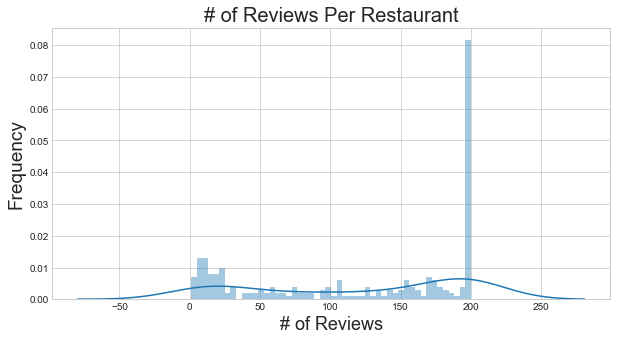

In [8]:
# plot distribution for the # of reviews per restaurant
sns_plot(plot_type='dist', x=reviews_df.restaurant_id.value_counts(), xlabel='# of Reviews', ylabel='Frequency', title='# of Reviews Per Restaurant', bins=50)

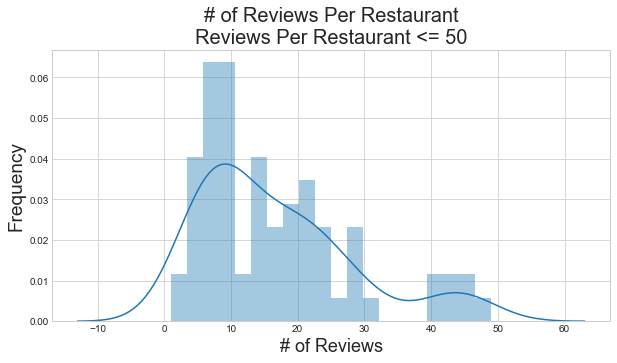

In [9]:
# plot distribution for the # of reviews given per restaurant, when the # of reviews is less than or equal to 50
sns_plot(plot_type='dist', x=reviews_df.restaurant_id.value_counts()[reviews_df.restaurant_id.value_counts()<=50], xlabel='# of Reviews', ylabel='Frequency', title='# of Reviews Per Restaurant\nReviews Per Restaurant <= 50')

In [10]:
#reviews_df.groupby('restaurant_id')['restaurant_id'].count().sort_values()
reviews_df[reviews_df.restaurant_id==16585728]

,review_id,restaurant_id,user_id,user_name,user_review_count,user_followers_count,review_date,star_rating,textual_review
15097,39694347,16585728,30333926,Ignatia,104,144.0,2018-10-20 10:14:04,5.0,I had the longest journey on tram just for the...


In [11]:
# no. of reviews per restaurant
review_count_per_restaurant = reviews_df.groupby('restaurant_id')['restaurant_id'].count()
review_count_per_restaurant.describe()

count    253.000000
mean     120.454545
std       76.993216
min        1.000000
25%       29.000000
50%      147.000000
75%      200.000000
max      200.000000
Name: restaurant_id, dtype: float64

In [12]:
# quantile range of review count per restaurant 
review_count_per_restaurant.quantile(np.arange(0,1,.05))

0.00      1.0
0.05      6.6
0.10     10.0
0.15     14.8
0.20     22.0
0.25     29.0
0.30     57.6
0.35     76.4
0.40    100.0
0.45    125.8
0.50    147.0
0.55    160.0
0.60    173.0
0.65    185.6
0.70    200.0
0.75    200.0
0.80    200.0
0.85    200.0
0.90    200.0
0.95    200.0
Name: restaurant_id, dtype: float64

In [13]:
# no. of restaurants with total reviews = 25
(review_count_per_restaurant==200).sum()

80

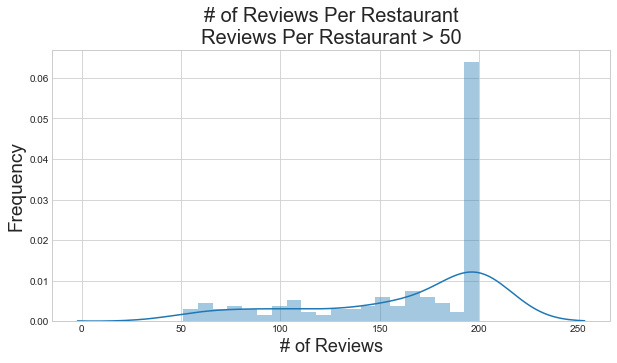

In [14]:
# plot distribution for the # of reviews given per restaurant, when the # of reviews is greater than 50
sns_plot(plot_type='dist', x=reviews_df.restaurant_id.value_counts()[reviews_df.restaurant_id.value_counts()>50], xlabel='# of Reviews', ylabel='Frequency', title='# of Reviews Per Restaurant\nReviews Per Restaurant > 50')

In [16]:
# set review_date column to datetime object
reviews_df.loc[:,'review_date'] = pd.to_datetime(reviews_df.review_date)

In [17]:
# drop the reviews with no star ratings - these reviews date back to the 2014-2015 period, thus, relevance-wise might be worth dropping
reviews_df.drop(index=reviews_df[reviews_df.star_rating.isnull()].index, inplace=True)

In [23]:
# change user_followers_count from NaN to zero
reviews_df.loc[reviews_df.user_followers_count.isnull(), 'user_followers_count'] = 0

In [24]:
# tally no. of restaurants with 1 review , and with less than 5 reviews
review_count_per_restaurant = reviews_df.groupby('restaurant_id')['restaurant_id'].count()
pd.DataFrame([(review_count_per_restaurant==1).sum(), (review_count_per_restaurant<5).sum()], columns=['Total'], index=['Restaurants with only 1 review', 'with less than 5 reviews']).T

,Restaurants with only 1 review,with less than 5 reviews
Total,1,7


In [25]:
# after above data preprocessing, show updated # of unique restaurants, users, and reviews in the dataset
pd.DataFrame([[len(businesses_df.restaurant_id.unique())], [len(reviews_df.user_id.unique())], [reviews_df.review_id.count()]], columns=['Total'], index = ['# of Restaurants', '# of Users', '# of Reviews']).T

,# of Restaurants,# of Users,# of Reviews
Total,253,12349,28491


In [ ]:
# # save dataframe as csv for backup reflecting all changes to this point
# businesses_df.to_pickle('./datasets/Zomato - All Cafes in Melbourne - pass 1.pkl')
# # save dataframe as for backup reflecting all changes to this point
# reviews_df.to_pickle('./datasets/reviews - clean - pass 1.pkl')

### ---------------------
#### Load from Pickle

In [ ]:
# businesses_df = pd.DataFrame()
# reviews_df = pd.DataFrame()
# # load the csv of the scraped businesses on to a dataframe
# businesses_df = pd.read_pickle('./datasets/Zomato - All Cafes in Melbourne - pass 1.pkl')
# # load the csv of the scraped reviews on to a dataframe
# reviews_df = pd.read_pickle('./datasets/reviews - clean - pass 1.pkl')

### ---------------------

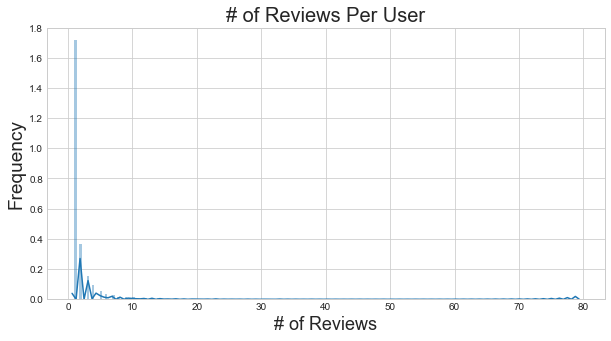

In [26]:
# plot distribution for the # of reviews given per user
sns_plot(plot_type='dist', x=reviews_df.user_id.value_counts(), xlabel='# of Reviews', ylabel='Frequency', title='# of Reviews Per User', bins=200)

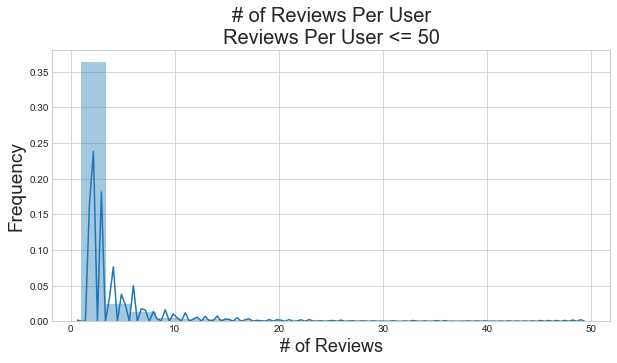

In [27]:
# plot distribution for the # of reviews given per user, when the # of reviews is less than or equal to 50
sns_plot(plot_type='dist', x=reviews_df.user_id.value_counts()[reviews_df.user_id.value_counts()<=50], xlabel='# of Reviews', ylabel='Frequency', title='# of Reviews Per User\nReviews Per User <= 50')

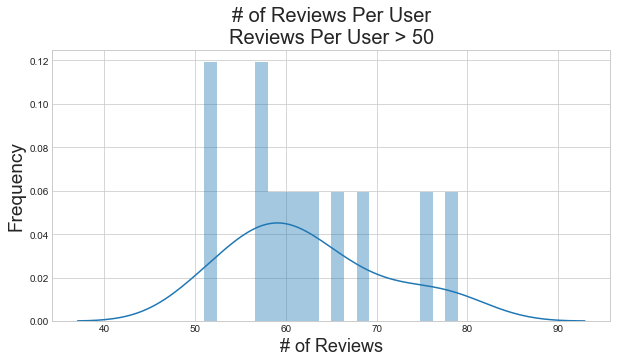

In [28]:
# plot distribution for the # of reviews given per user, when the # of reviews is greater than 50
sns_plot(plot_type='dist', x=reviews_df.user_id.value_counts()[reviews_df.user_id.value_counts()>50], xlabel='# of Reviews', ylabel='Frequency', title='# of Reviews Per User\nReviews Per User > 50')

In [29]:
# filter reviews dataset so that it only shows the 2018 reviews
reviews_df_2018 = reviews_df[reviews_df.review_date.dt.year == 2018]
reviews_df_2018 = reviews_df_2018[['restaurant_id','review_date', 'star_rating']]
reviews_df_2018.set_index('review_date',inplace=True)
reviews_df_2018.head()

,restaurant_id,star_rating
review_date,,
2018-11-12 14:56:58,16574679,5.0
2018-11-08 09:03:21,16574679,5.0
2018-09-28 20:38:18,16574679,4.0
2018-09-23 13:25:33,16574679,5.0
2018-09-20 17:21:03,16574679,5.0


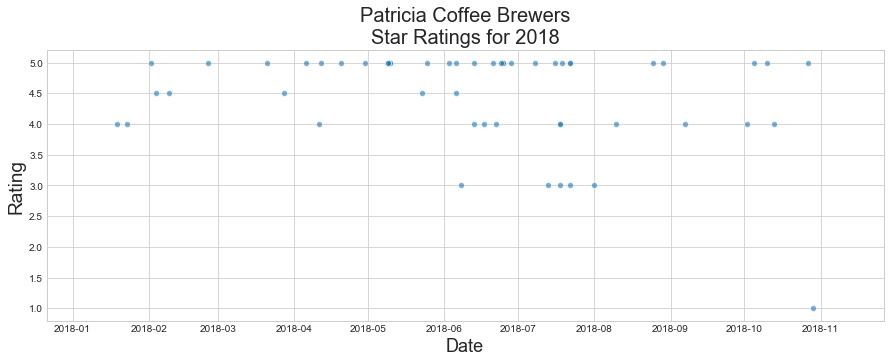

In [30]:
# latest 2018 ratings for a given restaurant 
rest_id = 16578793 # Patricia Coffee Brewers
rest_name = businesses_df[businesses_df.restaurant_id==rest_id]['name'].values[0]
per_restaurant_ratings_timeseries = reviews_df_2018[reviews_df_2018.restaurant_id==rest_id]
per_restaurant_ratings_timeseries.index = per_restaurant_ratings_timeseries.index.date
# plot star_rating for a particular restaurant
sns_plot(plot_type='scatter', x=per_restaurant_ratings_timeseries.index, y=per_restaurant_ratings_timeseries.star_rating, 
         xlabel='Date', ylabel='Rating', title=rest_name + '\n' + 'Star Ratings for 2018', figsize=(15,5))
#per_restaurant_ratings_timeseries.sort_index().head(25)

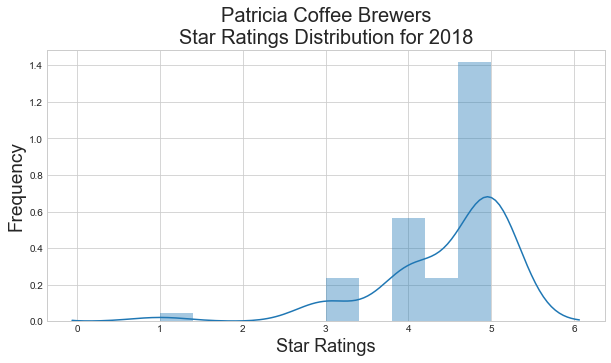

In [31]:
# plot distribution for the star ratings for a restaurant in 2018
sns_plot(plot_type='dist', x=per_restaurant_ratings_timeseries.star_rating, xlabel='Star Ratings', ylabel='Frequency', title=rest_name + '\nStar Ratings Distribution for 2018',bins=10)

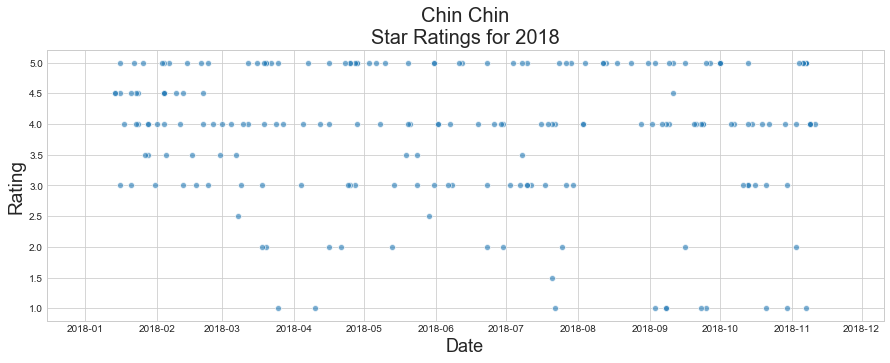

In [32]:
# latest 2018 ratings for a given restaurant 
rest_id = 16577492 # Chin Chin
rest_name = businesses_df[businesses_df.restaurant_id==rest_id]['name'].values[0]
per_restaurant_ratings_timeseries = reviews_df_2018[reviews_df_2018.restaurant_id==rest_id]
per_restaurant_ratings_timeseries.index = per_restaurant_ratings_timeseries.index.date
# plot star_rating for a particular restaurant
sns_plot(plot_type='scatter', x=per_restaurant_ratings_timeseries.index, y=per_restaurant_ratings_timeseries.star_rating, 
         xlabel='Date', ylabel='Rating', title=rest_name + '\n' + 'Star Ratings for 2018', figsize=(15,5))

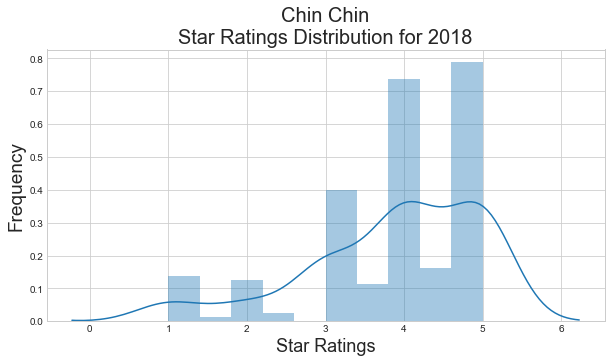

In [33]:
# plot distribution for the star ratings for a restaurant in 2018
sns_plot(plot_type='dist', x=per_restaurant_ratings_timeseries.star_rating, xlabel='Star Ratings', ylabel='Frequency', title=rest_name + '\nStar Ratings Distribution for 2018',bins=10)

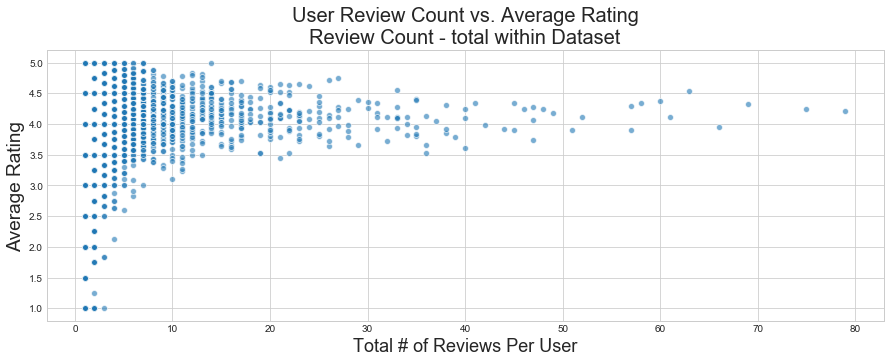

In [34]:
# checking correlation between a user's # of reviews IN the dataset and the user's average rating
review_count_per_user = reviews_df.groupby('user_id')['review_id'].count()
average_rating_per_user = reviews_df.groupby('user_id')['star_rating'].mean()
average_rating_review_count = pd.merge(pd.DataFrame(average_rating_per_user), pd.DataFrame(review_count_per_user), left_on='user_id', right_on='user_id')
sns_plot(plot_type='scatter', x=average_rating_review_count.review_id, y=average_rating_review_count.star_rating,
         xlabel='Total # of Reviews Per User', ylabel='Average Rating', title='User Review Count vs. Average Rating\nReview Count - total within Dataset', figsize=(15,5))

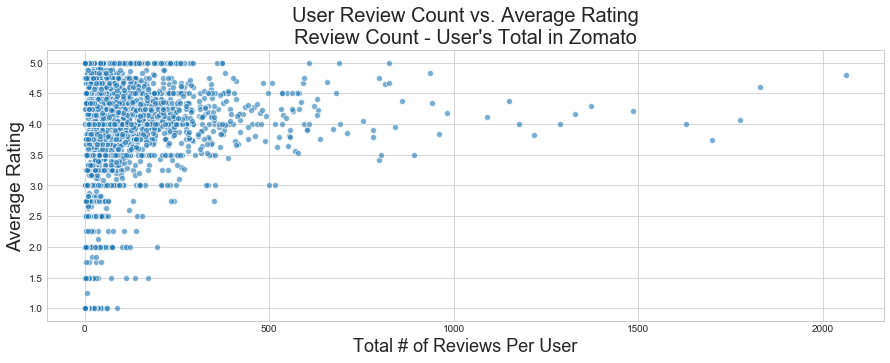

In [35]:
# checking correlation between a user's # of reviews (profiled as overall total in Zomato) and the user's average rating
average_rating_per_user = pd.DataFrame(reviews_df.groupby('user_id')['star_rating'].mean())
average_rating_per_user['total_review_count'] = average_rating_per_user.index.map(lambda x: np.max(reviews_df[reviews_df.user_id == x]['user_review_count']))
sns_plot(plot_type='scatter', x=average_rating_per_user.total_review_count, y=average_rating_per_user.star_rating,
         xlabel='Total # of Reviews Per User', ylabel='Average Rating', title="User Review Count vs. Average Rating\nReview Count - User's Total in Zomato", figsize=(15,5))

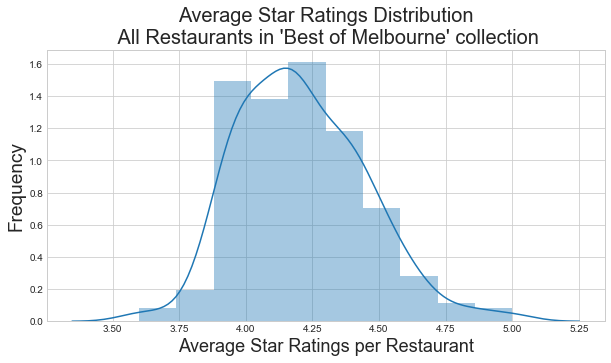

In [37]:
# plot distribution for the average star ratings of all restaurants in the dataset
rating_mean_df = reviews_df.groupby('restaurant_id')['star_rating'].mean()
sns_plot(plot_type='dist', x=rating_mean_df, xlabel='Average Star Ratings per Restaurant', ylabel='Frequency', title="Average Star Ratings Distribution\n All Restaurants in 'Best of Melbourne' collection",bins=10)


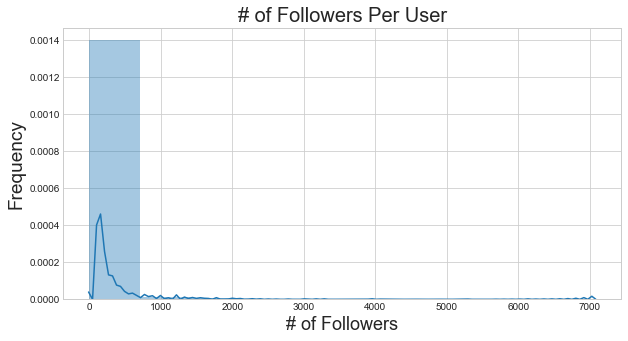

In [38]:
# plot distribution for the average followers count of all users in the dataset
rating_mean_df = reviews_df.groupby('user_id')['user_followers_count'].mean()
sns_plot(plot_type='dist', x=rating_mean_df, xlabel='# of Followers', ylabel='Frequency', title="# of Followers Per User",bins=10)

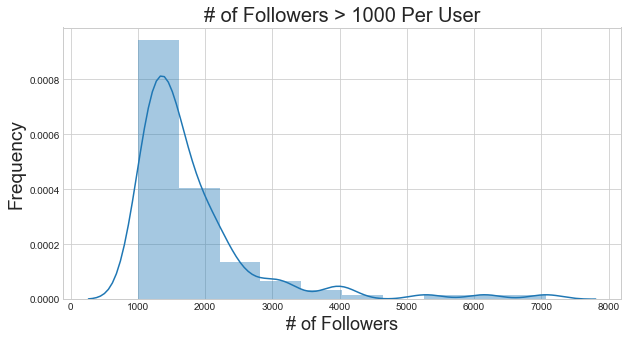

In [39]:
# plot distribution for the average followers count of all users in the dataset
followers_mean_df = reviews_df[reviews_df.user_followers_count>=1000].groupby('user_id')['user_followers_count'].mean()
sns_plot(plot_type='dist', x=followers_mean_df, xlabel='# of Followers', ylabel='Frequency', title="# of Followers > 1000 Per User",bins=10)

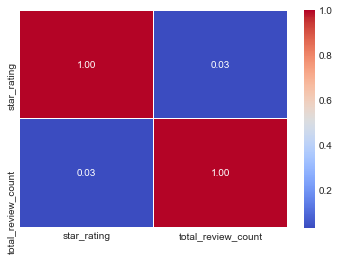

In [41]:
# heatmap shows there is virtually no correlation between average rating per user and total review count per user, even when setting # of reviews greater than 650
sns.heatmap(average_rating_per_user[average_rating_per_user.total_review_count > 650].corr(), annot=True, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)

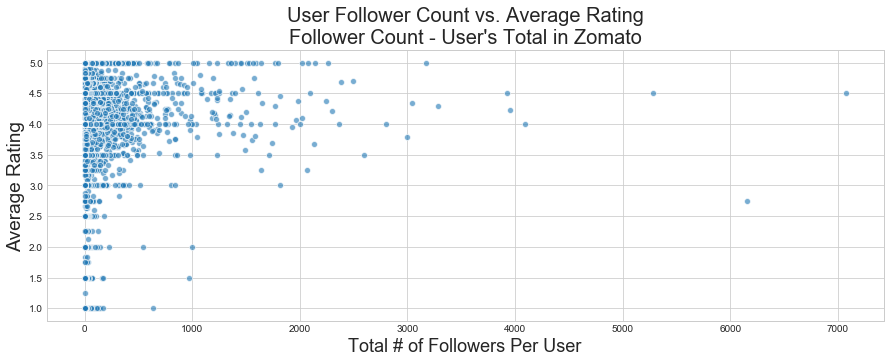

In [42]:
# checking correlation between a user's # of followers (profiled as overall total in Zomato) and the user's average rating
average_rating_follower_per_user = pd.DataFrame(reviews_df.groupby('user_id')['star_rating'].mean())
average_rating_follower_per_user['total_follower_count'] = average_rating_follower_per_user.index.map(lambda x: np.max(reviews_df[reviews_df.user_id == x]['user_followers_count']))
sns_plot(plot_type='scatter', x=average_rating_follower_per_user.total_follower_count, y=average_rating_follower_per_user.star_rating,
         xlabel='Total # of Followers Per User', ylabel='Average Rating', title="User Follower Count vs. Average Rating\nFollower Count - User's Total in Zomato", figsize=(15,5))

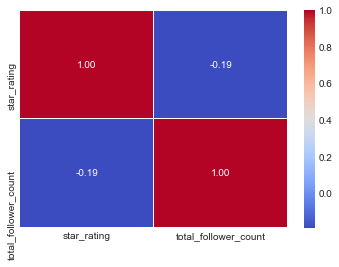

In [43]:
# heatmap shows a slight correlation between star rating and total follower count of a user, even when # of followers is greater than 1000
# testing the effect to star ratings provided when the # of followers is high - very slight correlation exists
sns.heatmap(average_rating_follower_per_user[average_rating_follower_per_user.total_follower_count > 1000].corr(), annot=True, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)

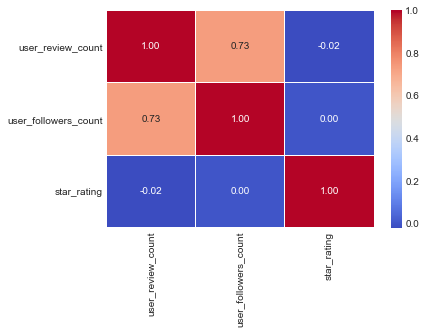

In [44]:
# heatmap below shows good correlation between user_review_count and user_follower_count;
# it also shows no correlation between star_rating and the each of the former 2 features
sns.heatmap(reviews_df[['user_review_count','user_followers_count','star_rating']].corr(), annot=True, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)

In [45]:
# combine 2 dataframes by column, retaining the index of the left dataframe
def append_dataframes_by_column_retain_left_index(df_left, df_right):

    # change right dataframe's index to be the same as the left dataframe
    df_right.set_index(df_left.index,inplace=True)
    # concatenate the 2 dataframes by the columns
    df_left = pd.concat([df_left,df_right],axis=1)

    return df_left

In [46]:
def dummify_columns(df, columns_to_dummify_list):

    # for every column to dummify
    for column in columns_to_dummify_list:

        # fit labelbinarizer to job_category_1 column
        lb = preprocessing.LabelBinarizer(sparse_output=True)
        dummies_sparse = lb.fit_transform(df[column])

        # dummify values to a matrix and load on to a dataframe
        column_names = [(column + '_' + dummy_class) for dummy_class in lb.classes_]
        df_dummies = pd.DataFrame(dummies_sparse.todense(), columns=column_names)
        # drop last column for dummies (to dummify - 1)
        df_dummies.drop(df_dummies.columns[-1], axis=1, inplace=True)
        # drop the original column (the one dummies were based on)
        df.drop(column, axis=1, inplace=True)
        # combine the 2 dataframes, retaining the left dataframe's index
        df = append_dataframes_by_column_retain_left_index(df,df_dummies)
    
    return df

### Slicing the dataset
Trimming the dataset down may be necessary to increase the relevance of the results generated from a recommender system. 

As an example, if the restaurants were filtered to those that have at least 20 reviews, thus disregarding those that have less than 20 reviews and effectively impacting the number of users and reviews left in the dataset, then the recommender would be able to provide more useful recommendations. These recommendations are ideally calculated with user-item and item-item collaborative filtering methods.

In [47]:
# assess the impact of slicing the dataset by analyzing the resulting number of restaurants, users, and ratings
def assess_slice_dataset(minimum_count, slice_on_feature, reviews_df):
    
    reviews_sliced = reviews_df.copy()

    # if slicing is based on the feature restaurant_id
    if slice_on_feature == 'restaurant_id':
        
        # get the count of reviews per restaurant
        review_count_per_restaurant = reviews_sliced.groupby('restaurant_id')['restaurant_id'].count()
        # filter to restaurants that satisfy the minimum # of reviews requirement
        review_count_per_restaurant = review_count_per_restaurant[review_count_per_restaurant>=minimum_count]
        # get the restaurant_id's
        feature_ids = list(review_count_per_restaurant.index)

        # apply filter to dataset
        reviews_sliced = reviews_sliced[reviews_sliced.restaurant_id.isin(feature_ids)]

        # count # of restaurants
        restaurant_count = len(feature_ids)
        # count # of users who left review(s) to one or more of these restaurants
        user_count = reviews_sliced.user_id.nunique()
        
    # if slicing is based on the feature user_id
    elif slice_on_feature == 'user_id':
        # get the count of reviews per user
        review_count_per_user = reviews_sliced.groupby('user_id')['user_id'].count()
        # filter to users that satisfy the minimum # of reviews requirement
        review_count_per_user = review_count_per_user[review_count_per_user>=minimum_count]
        # get the user_id's
        feature_ids = list(review_count_per_user.index)

        # apply filter to dataset
        reviews_sliced = reviews_sliced[reviews_sliced.user_id.isin(feature_ids)]    

        # count # of restaurants
        restaurant_count = reviews_sliced.restaurant_id.nunique()
        # count # of users who left review(s) to one or more of these restaurants
        user_count = len(feature_ids)
    
    # count # of reviews for these restaurants
    review_count = reviews_sliced.review_id.count()

    display('Sliced by ' + slice_on_feature + '; minimum count at ' + str(minimum_count))
    display('Remaining # of restaurants: ' + str(restaurant_count))
    display('Remaining # of users: ' + str(user_count))
    display('Remaining # of reviews: ' + str(review_count))
    display('Reviews to matrix size ratio: ' + str(review_count / (restaurant_count * user_count)))
    display('-' * 20)
    return reviews_sliced

In [ ]:
# # slice the dataset with these criteria

# # slice dataset to filter to restaurants with 25 or more reviews
# reviews_sliced = assess_slice_dataset(25, 'restaurant_id', reviews_df)
# # slice dataset to filter to users with 5 or more reviews in the dataset
# reviews_sliced = assess_slice_dataset(10, 'user_id', reviews_sliced)
# reviews_sliced = assess_slice_dataset(5, 'restaurant_id', reviews_sliced)

In [ ]:
# # slice the dataset with these criteria

# #reviews_sliced = assess_slice_dataset(25, 'restaurant_id', reviews_df)
# reviews_sliced = assess_slice_dataset(10, 'user_id', reviews_df)
# reviews_sliced = assess_slice_dataset(10, 'restaurant_id', reviews_sliced)
# reviews_sliced = assess_slice_dataset(5, 'user_id', reviews_sliced)

### Train-Dev-Test split the dataset

In [48]:
# split into to train and test sets
train_reviews_df, test_reviews_df = train_test_split(reviews_df, test_size=0.2, random_state=42)

# split train further into train and dev sets
train_reviews_df, dev_reviews_df = train_test_split(train_reviews_df, test_size=0.2, random_state=42)

# display shapes
print('Full data : ',  reviews_df.shape)
print('Train set : ', train_reviews_df.shape)
print('Dev set : ',  dev_reviews_df.shape)
print('Test set : ', test_reviews_df.shape)

Full data :  (28491, 9)
Train set :  (18233, 9)
Dev set :  (4559, 9)
Test set :  (5699, 9)


In [49]:
# total # of unique restaurants, users, and reviews before dataset split
stat_before_split = pd.DataFrame([[len(reviews_df.restaurant_id.unique())], [len(reviews_df.user_id.unique())], [reviews_df.review_id.count()]], columns=['Total before Split'], index = ['# of Restaurants', '# of Users', '# of Reviews']).T
display(stat_before_split.head())
# total # of unique restaurants, users, and reviews for train dataset
stat_train = pd.DataFrame([[len(train_reviews_df.restaurant_id.unique())], [len(train_reviews_df.user_id.unique())], [train_reviews_df.review_id.count()]], columns=['Total for Train set'], index = ['# of Restaurants', '# of Users', '# of Reviews']).T
display(stat_train.head())
# total # of unique restaurants, users, and reviews for dev dataset
stat_dev = pd.DataFrame([[len(dev_reviews_df.restaurant_id.unique())], [len(dev_reviews_df.user_id.unique())], [dev_reviews_df.review_id.count()]], columns=['Total for Dev set'], index = ['# of Restaurants', '# of Users', '# of Reviews']).T
display(stat_dev.head())
# total # of unique restaurants, users, and reviews for test dataset
stat_test = pd.DataFrame([[len(test_reviews_df.restaurant_id.unique())], [len(test_reviews_df.user_id.unique())], [test_reviews_df.review_id.count()]], columns=['Total for Test set'], index = ['# of Restaurants', '# of Users', '# of Reviews']).T
display(stat_test.head())

,# of Restaurants,# of Users,# of Reviews
Total before Split,253,12349,28491


,# of Restaurants,# of Users,# of Reviews
Total for Train set,253,9035,18233


,# of Restaurants,# of Users,# of Reviews
Total for Dev set,243,3249,4559


,# of Restaurants,# of Users,# of Reviews
Total for Test set,242,3859,5699


In [50]:
# prepare matrices for the recommender system (change null rating to 2.5)
main_matrix = reviews_df.pivot_table(values='star_rating', columns='restaurant_id', index='user_id').fillna(2.5)
train_matrix = train_reviews_df.pivot_table(values='star_rating', columns='restaurant_id', index='user_id').fillna(2.5)
dev_matrix = dev_reviews_df.pivot_table(values='star_rating', columns='restaurant_id', index='user_id').fillna(2.5)
test_matrix = test_reviews_df.pivot_table(values='star_rating', columns='restaurant_id', index='user_id').fillna(2.5)

In [51]:
matrix_shape_list = [main_matrix.shape,train_matrix.shape,dev_matrix.shape,test_matrix.shape]
row_list = []
column_list = []
for shape_row, shape_column in matrix_shape_list:
    row_list.append(shape_row)
    column_list.append(shape_column)

matrix_shapes_df = pd.DataFrame({'# of Rows':row_list, '# of Columns:':column_list}, index=['Full matrix','Train matrix','Dev matrix','Test matrix'])
matrix_shapes_df.head()

,# of Rows,# of Columns:
Full matrix,12349,253
Train matrix,9035,253
Dev matrix,3249,243
Test matrix,3859,242


In [52]:
# check sparsity level of a matrix-form dataset
def get_matrix_sparsity(matrix_df, desc):
    sparsity = round((matrix_df==2.5).sum().sum() / float(matrix_df.shape[0]*matrix_df.shape[1]),3) * 100
    print("The sparsity level of " + desc + " dataset is " +  str(sparsity) + '%')
    return sparsity

In [53]:
# check sparsity level of the matrices
sparsity_list = [get_matrix_sparsity(main_matrix,'Best of Melbourne - main'), get_matrix_sparsity(train_matrix, 'Best of Melbourne - train'), get_matrix_sparsity(dev_matrix, 'Best of Melbourne - dev'), get_matrix_sparsity(test_matrix, 'Best of Melbourne - test')]

The sparsity level of Best of Melbourne - main dataset is 99.1%
The sparsity level of Best of Melbourne - train dataset is 99.2%
The sparsity level of Best of Melbourne - dev dataset is 99.4%
The sparsity level of Best of Melbourne - test dataset is 99.4%


In [54]:
# get the top n restaurants with the most # of m ratings, where m can be a single or a list of ratings 
def get_n_restaurants_with_m_ratings(assess_reviews_df, restaurant_count, ratings_list):    
    top_n_restaurants_with_m_ratings = assess_reviews_df[assess_reviews_df.star_rating.isin(ratings_list)].groupby('restaurant_id')['restaurant_id'].count().sort_values(ascending=False).head(restaurant_count)
    top_n_restaurants_df = businesses_df[businesses_df.restaurant_id.isin(top_n_restaurants_with_m_ratings.index[:restaurant_count])][['restaurant_id','name']].set_index('restaurant_id')
    top_n_restaurants_df = top_n_restaurants_df.join(top_n_restaurants_with_m_ratings, how='inner')

    star_column_label = ''
    for rating in ratings_list:
        if ratings_list[0]==rating:
            star_column_label = str(rating)
        else:
            star_column_label += '/' + str(rating)
    star_column_label += ' Star Rating Count'

    top_n_restaurants_df.rename(columns={'name': 'Name', 'restaurant_id': star_column_label},inplace=True)
    return top_n_restaurants_df.sort_values(star_column_label, ascending=False)

In [55]:
# select a random restaurant from the ratings matrix
def get_random_restaurant_from_matrix(top_n_restaurants_df):
    random_index = np.random.choice(np.arange(0, top_n_restaurants_df.shape[0]), size=1)
    subject_restaurant = pd.DataFrame(train_matrix.loc[:,top_n_restaurants_df.index[random_index[0]]])
    return subject_restaurant

### Personal Favorites-Based Recommendation
The objective is to generate a Top-N Recommended Restaurants list based on a user's history of 5 star rated restaurants, sorted chronologically. This basically reminds the user of the restaurants that he/she previously rated highly and thus can be revisited.

In [56]:
# list # of reviews per user (to spot the most active reviewers) in the dataset
# choose one user in this list to test the personal favorites-based recommendation
reviews_df.groupby('user_id')['restaurant_id'].count().sort_values(ascending=False).head()

user_id
37495749    79
25511321    75
41473737    69
30863711    66
47875655    63
Name: restaurant_id, dtype: int64

In [57]:
# Get the subject user's 5-star rated srestaurants, sorted chronologically
# performing this against the entire dataset, rather than limiting it to the training set,
# for the purpose of maximizing the entire list of reviews of a given user and, thus, yield more insightful results

# choose subject user
subject_user = train_matrix.sample()
subject_user.head()
# for testing: set subject user to the one with the highest # of reviews in the dataset
subject_user = train_matrix[train_matrix.index==37495749]

# get the restaurants rated with 5 stars by subject user
personal_favorites_df = reviews_df[(reviews_df.user_id==subject_user.index[0]) & (reviews_df.star_rating.isin([5]))][['restaurant_id','user_id','user_name','review_date','star_rating','textual_review']].sort_values('review_date',ascending=False).set_index('user_id')
user_name = personal_favorites_df.iloc[0,1]

#businesses_df[['restaurant_id', 'name']].set_index('restaurant_id')

personal_favorites_df = personal_favorites_df.merge(businesses_df[['restaurant_id','name']], on='restaurant_id') #left_on=personal_favorites_df.index, right_on='restaurant_id')
personal_favorites_df = personal_favorites_df[['review_date','name','star_rating','textual_review']]
personal_favorites_df = personal_favorites_df.rename(columns={'review_date':'Review Date', 'name':'Restaurant Name', 'star_rating':'Star Rating', 'textual_review': 'Review'}).set_index('Review Date')

# Get the top 10 restaurants in the entire dataset with the most # of 5-Star Ratings

display('User Name: ' + str(user_name))
display('Personal Favorites: 5 Star Rated Restaurants sorted chronologically (entire dataset):')
display(personal_favorites_df.head(10))

'User Name: Good Food Good Mood'

'Personal Favorites: 5 Star Rated Restaurants sorted chronologically (entire dataset):'

,Restaurant Name,Star Rating,Review
Review Date,,,
2018-11-05 03:55:06,Fourth Chapter,5.0,We were invited to Fourth Chapter today and we...
2018-10-08 04:52:15,Roasting Warehouse,5.0,We were invited to Roasting Warehouse on Satur...
2018-09-29 04:15:12,Dish & Spoon,5.0,We were invited to Dish and Spoon yesterday an...
2018-09-25 11:11:18,Old School Pizza,5.0,I was so excited to be invited to Old School p...
2018-09-17 10:16:33,Project 281 Cafe,5.0,We were invited to Project 281 and wow what an...
2018-08-21 03:55:43,Izakaya Kuuraku,5.0,"We were invited to Izakaya Kuuraku last night,..."
2018-07-28 12:27:58,Burger Shurger,5.0,Being a massive butter chicken fan I was thril...
2018-07-28 12:07:51,The White Elephant Sri Lankan Cuisine,5.0,When I received the invitation to visit White ...
2018-07-15 07:04:04,No.19,5.0,I was invited to No19 this morning and it was ...


### Popularity-Based Recommendation
The objective is to generate a Top-N Recommended Restaurants list for the restaurants with the highest number of 5-star ratings. 

In [58]:
# Get the top 10 restaurants in the entire dataset with the most # of 5-Star Ratings
restaurant_count=10
ratings_list=[5]
top_n_restaurants_df = get_n_restaurants_with_m_ratings(reviews_df, restaurant_count, ratings_list)
display('Popularity-Based: Top 10 Restaurants with most 5-Star Ratings (entire dataset):')
display(top_n_restaurants_df.head(restaurant_count))

'Popularity-Based: Top 10 Restaurants with most 5-Star Ratings (entire dataset):'

,Name,5 Star Rating Count
restaurant_id,,
16586502,Full Turn Kitchen Bar,139
17881527,Dexter,125
18418602,Shanklin Cafe,125
16582770,Rice Workshop,118
16570775,Attica,110
17849355,Urban Projuice,110
18106852,Dinner by Heston Blumenthal,107
16583098,Lune Croissanterie,104
16586014,Minamishima,96


In [59]:
# Get the top 10 restaurants in the train set with the most # of 5-Star Ratings
restaurant_count=10
ratings_list=[5]
top_n_restaurants_df = get_n_restaurants_with_m_ratings(train_reviews_df, restaurant_count, ratings_list)
display('Popularity-Based: Top 10 Restaurants with most 5-Star Ratings (train set):')
display(top_n_restaurants_df.head(restaurant_count))

'Popularity-Based: Top 10 Restaurants with most 5-Star Ratings (train set):'

,Name,5 Star Rating Count
restaurant_id,,
16586502,Full Turn Kitchen Bar,95
16582770,Rice Workshop,79
17881527,Dexter,77
17849355,Urban Projuice,74
16583098,Lune Croissanterie,72
18106852,Dinner by Heston Blumenthal,71
18418602,Shanklin Cafe,71
16570775,Attica,67
16586014,Minamishima,61


In [60]:
# Get the top 10 restaurants in the dev set with the most # of 5-Star Ratings
restaurant_count=10
ratings_list=[5]
top_n_restaurants_df = get_n_restaurants_with_m_ratings(dev_reviews_df, restaurant_count, ratings_list)
display('Popularity-Based: Top 10 Restaurants with most 5-Star Ratings (dev set):')
display(top_n_restaurants_df.head(restaurant_count))

'Popularity-Based: Top 10 Restaurants with most 5-Star Ratings (dev set):'

,Name,5 Star Rating Count
restaurant_id,,
18418602,Shanklin Cafe,30
18106852,Dinner by Heston Blumenthal,22
16586502,Full Turn Kitchen Bar,20
16570775,Attica,19
16582770,Rice Workshop,19
17849355,Urban Projuice,17
17989264,Faraday's Cage,16
17881527,Dexter,16
16583098,Lune Croissanterie,16


In [61]:
# Get the top 10 restaurants in the test set with the most # of 5-Star Ratings
restaurant_count=10
ratings_list=[5]
top_n_restaurants_df = get_n_restaurants_with_m_ratings(test_reviews_df, restaurant_count, ratings_list)
display('Popularity-Based: Top 10 Restaurants with most 5-Star Ratings (test set):')
display(top_n_restaurants_df.head(restaurant_count))

'Popularity-Based: Top 10 Restaurants with most 5-Star Ratings (test set):'

,Name,5 Star Rating Count
restaurant_id,,
17881527,Dexter,32
16570775,Attica,24
16586502,Full Turn Kitchen Bar,24
18418602,Shanklin Cafe,24
16586014,Minamishima,23
18564046,Homi Noodle Bar,22
18397850,Aunty Franklee,21
16582573,Mr. Miyagi,21
16578793,Patricia Coffee Brewers,21


### Content-Based Filtering
The objective is to generate a Top-N Recommended Restaurants list based on the proximity (distance) of the restaurant from the user's current address. This will be updated to accommodate user input, but for now, the user address is set statically for demo purposes.

In [62]:
# extract location dictionary into separate columns
businesses_df['location_address'] = businesses_df['location'].apply(lambda x: x['address'])
businesses_df['location_locality'] = businesses_df['location'].apply(lambda x: x['locality'])
businesses_df['location_city'] = businesses_df['location'].apply(lambda x: x['city'])
businesses_df['location_latitude'] = businesses_df['location'].apply(lambda x: x['latitude'])
businesses_df['location_longitude'] = businesses_df['location'].apply(lambda x: x['longitude'])
businesses_df['location_zipcode'] = businesses_df['location'].apply(lambda x: x['zipcode'])
businesses_df['location_country_id'] = businesses_df['location'].apply(lambda x: x['country_id'])
# drop location column
businesses_df.drop(columns='location',inplace=True)

In [63]:
# obtain the latitude/longitude for a given address
def get_lat_long_given_address(current_address):
    geolocator = Nominatim(user_agent="zmatorecsys")
    location = geolocator.geocode(current_address)
    current_lat_long = (location.latitude, location.longitude)
    #print(current_lat_long)    
    return current_lat_long

In [64]:
# compare distances from current location to each of the restaurants in the given dataframe, get top n closest
def get_distance_to_restaurants(assess_businesses_df, current_lat_long):

    restaurant_id_list = []
    distance_to_restaurants_list = []

    # get distance to each restaurant
    for key, restaurant in assess_businesses_df.iterrows():
        # get geodesic distance between 2 locations    
        #print(restaurant)
        dest_loc=(restaurant.location_latitude, restaurant.location_longitude)
        distance_to_restaurants_list.append(round(geodesic(current_lat_long, dest_loc).kilometers, 2))
        restaurant_id_list.append(restaurant.restaurant_id)

    # save restaurant_id's and their respective distances to a dataframe
    distance_to_restaurants_df = pd.DataFrame({'restaurant_id': restaurant_id_list, 'Distance(km)': distance_to_restaurants_list})
    distance_to_restaurants_df = assess_businesses_df[['restaurant_id','name']].merge(distance_to_restaurants_df, left_on='restaurant_id', right_on='restaurant_id')
    distance_to_restaurants_df.rename(columns={'name': 'Name'}, inplace=True)
    distance_to_restaurants_df.set_index('restaurant_id', inplace=True);
    
    return distance_to_restaurants_df

In [65]:
# Using Geocoder - test only - get current position's lat and long
# location is based on ip - if ip is not static, location may refer back to an exchange/node or address related to the ISP
import geocoder
g = geocoder.ip('me')
print(g.latlng)

[-37.75, 145.017]


In [66]:
# set current address
current_address = "45 William St Melbourne"

# get current location coordinates
current_lat_long = get_lat_long_given_address(current_address)

# get distances from current address to all restaurants in the dataset
distance_to_restaurants_df = get_distance_to_restaurants(businesses_df, current_lat_long)

display('Current Location: ' + current_address)
display('Content-Based Filtering: "Restaurants that are Nearby"')
distance_to_restaurants_df.sort_values('Distance(km)').head(10)

'Current Location: 45 William St Melbourne'

'Content-Based Filtering: "Restaurants that are Nearby"'

,Name,Distance(km)
restaurant_id,,
16578480,The Lui Bar,0.13
16583589,Goz City,0.22
16573759,Le Petit Gateau,0.24
18279069,Massi,0.24
16581462,The Grain Store,0.26
16571812,Maha Restaurant,0.31
16576105,Guhng,0.41
16576477,Purple Peanuts Japanese Cafe,0.41
16572201,Red Spice Road,0.41


In [67]:
# Google Maps API - get distance, duration of travel, duration of travel with traffic
# use Google Maps API sparingly, limit it to the 'last leg' of the distance computation, due to its pay-after-n-calls
# once the top results (closest restaurants, in this case) are obtained through geopy's geocode, recompute the Google Map Client's geocode for both the source location and destination location 
# (refer to google map's own lat long data given the address, as lat/long coordinates are inconsistent between geopy and Google Maps)
api_key = <api-key-here>
gm_client = googlemaps.Client(key=api_key)

# get current location lat/long using Google Maps API
gm_geocode = gm_client.geocode(current_address)
gm_current_lat_long = tuple(gm_geocode[0]['geometry']['location'].values())
# get destination location lat/long using Google Maps API

# get address and lat/long data of closest restaurant
closest_restaurant_id = distance_to_restaurants_df.sort_values('Distance(km)').head(1).index[0]
dest_address = businesses_df[businesses_df.restaurant_id==closest_restaurant_id]['location_address'].values[0]
gm_geocode = gm_client.geocode(dest_address)
gm_dest_lat_long = tuple(gm_geocode[0]['geometry']['location'].values())

# get and display distance details
display('Geo data for closest restaurant via Google Maps:')
display(distance_to_restaurants_df.sort_values('Distance(km)').head(1))
display(gm_client.distance_matrix(gm_current_lat_long, gm_dest_lat_long, departure_time=datetime.datetime.now()))

'Geo data for closest restaurant via Google Maps:'

,Name,Distance(km)
restaurant_id,,
16578480,The Lui Bar,0.13


{'destination_addresses': ['520 Collins St, Melbourne VIC 3000, Australia'],
 'origin_addresses': ['45 William St, Melbourne VIC 3000, Australia'],
 'rows': [{'elements': [{'distance': {'text': '0.3 km', 'value': 305},
     'duration': {'text': '2 mins', 'value': 94},
     'duration_in_traffic': {'text': '2 mins', 'value': 92},
     'status': 'OK'}]}],
 'status': 'OK'}

In [68]:
# To-Do: enhance Content-Based Recommendation by incorporating price range  
businesses_df[businesses_df.price_range==4][['price_range', 'average_cost_for_two']].sort_values('average_cost_for_two')
#businesses_df.price_range, businesses_df.average_cost_for_two

,price_range,average_cost_for_two
185,4,100
54,4,100
138,4,100
193,4,100
159,4,100
123,4,100
158,4,100
175,4,100
41,4,100
172,4,110


### Memory-Based Collaborative Filtering
#### Memory-Based Techniques explored below are as follows:
1. User-Item Collaborative Filtering via User Similarity (pairwise-cosine distance)
2. Item-Item Collaborative Filtering via Item Similarity (pairwise-cosine distance)
3. Item-Item Collaborative Filtering via Item Similarity with Rating Prediction (pairwise-cosine distance)
4. Item-Item Collaborative Filtering via Item Similarity with Rating Prediction (pairwise-cosine SIMILARITY)

In [69]:
# generate user-based and item-based similarity matrices
user_similarity = pairwise_distances(train_matrix, metric='cosine')
# get pairwise distances for item-item similarity using cosine as metric
item_similarity = pairwise_distances(train_matrix.T, metric='cosine')

### User-Item Collaborative Filtering - (pairwise-cosine distance)
The objective is to generate a Top-N Recommended Restaurants list based on a user's similarity of rating behavior with other users. To do this, cosine distance is used as a metric.

In [70]:
# choose subject user
subject_user = train_matrix.sample()
subject_user.head()

restaurant_id,16570683,16570741,16570775,16570776,16570811,16570910,16570927,16571138,16571144,16571189,...,18628562,18632069,18638034,18650646,18651260,18668223,18668229,18702410,18704117,18708512
user_id,,,,,,,,,,,,,,,,,,,,,
29692095,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,...,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5


In [71]:
# list the subject user's reviews
train_reviews_df[train_reviews_df.user_id == subject_user.index[0]]

,review_id,restaurant_id,user_id,user_name,user_review_count,user_followers_count,review_date,star_rating,textual_review
9442,28519169,16586014,29692095,Rachel Zhou,23,16.0,2016-10-19 15:03:41,5.0,Wonderful place for sushi and love the atmosph...
16057,29506538,16574818,29692095,Rachel Zhou,23,16.0,2017-02-16 08:59:50,4.0,Open environment and bright settings. Really e...
10742,31003541,18397850,29692095,Rachel Zhou,23,16.0,2017-07-12 12:54:46,4.0,Hands down the best Bak Kut Teh I had in Melbo...
19101,31763545,18340002,29692095,Rachel Zhou,23,16.0,2017-09-17 13:16:26,4.0,I loved the freshness and juicy taste of their...


In [72]:
# perform pairwise distance - subject user and user-item matrix
per_user_similarity = pairwise_distances(subject_user.values.reshape(1,-1), train_matrix,  metric='cosine')

In [73]:
# list and sort (by highest to lowest similarity) the users relative to the subject user
per_user_similarity_series = pd.Series(per_user_similarity.flatten(), index=train_matrix.index)

In [74]:
# get mean value for each column
def get_mean_per_column(x):
    # change 2.5 (un-rated) to zero
    x.replace(2.5,0, inplace=True)
    if (x != 0).sum()>0: 
        return x.sum()/(x != 0).sum()
    else:
        return 0 

In [75]:
# prepare businesses key columns, for merging with recommender df
restaurant_names_df = businesses_df[['restaurant_id','name']]
restaurant_names_df['overall_rating'] = businesses_df.user_rating.apply(lambda x: x['aggregate_rating'])
restaurant_names_df.head()

,restaurant_id,name,overall_rating
0,16574679,Highline,4.6
1,18274417,Vaporetto Bar & Eatery,4.5
2,18577082,Fujitei,4.8
3,18420698,Le Clec,4.7
4,16584360,Suda,4.5


In [127]:
# choose top n most similar users to subject user
top_similar_users = per_user_similarity_series.sort_values().iloc[:100]

# get their restaurant ratings
top_similar_users = train_matrix[train_matrix.index.isin(top_similar_users.index)]

# filter to those restaurants that subject user hasn't rated
user_item_recommended_restaurants_df = top_similar_users.loc[:, (subject_user == 2.5).values.flatten()]

# convert 2.5's to zero and get the mean of the ratings per restaurant that subject user hasn't tried/rated
user_item_recommended_restaurants_df = pd.DataFrame(user_item_recommended_restaurants_df.apply(get_mean_per_column), columns=['Similarity (High to Low)'])

# show top 5 recommended, append restaurant name
user_item_recommended_restaurants_df = user_item_recommended_restaurants_df.merge(restaurant_names_df, left_on=user_item_recommended_restaurants_df.index, right_on='restaurant_id')
user_item_recommended_restaurants_df.set_index('restaurant_id',inplace=True)
user_item_recommended_restaurants_df.index.name = 'User-Item CF: Top 5 Restaurants'
user_item_recommended_restaurants_df = user_item_recommended_restaurants_df[['name', 'overall_rating', 'Similarity (High to Low)']]
user_item_recommended_restaurants_df.rename(columns={'name': 'Name', 'overall_rating': 'Restaurant Overall Rating'}, inplace=True)
print('User-Item Collaborative Filtering (pairwise-cosine distance)')
user_item_recommended_restaurants_df.sort_values('Similarity (High to Low)', ascending=True).head(10)

User-Item Collaborative Filtering (pairwise-cosine distance)


,Name,Restaurant Overall Rating,Similarity (High to Low)
User-Item CF: Top 5 Restaurants,,,
16570683,A1 Bakery,4.5,0.0
16586688,Sir Charles,4.6,0.0
16598244,Phuoc Thanh,4.7,0.0
16713155,Mörk Chocolate Brew House,4.7,0.0
16713366,Smith and Deli,4.7,0.0
16713686,Laneway Greens,4.5,0.0
16713830,Bibelot,4.8,0.0
17849355,Urban Projuice,4.6,0.0
17849463,Goodovening,4.5,0.0


### Item-Item Collaborative Filtering - (pairwise-cosine distance)
The objective is to generate a Top-N Recommended Restaurants list based on a user's list of high-rated items, as well as their similarity with the list of ratings of other items. Items in this case are restaurants. If a user hasn't rated any restaurants with a high rating (4-star or 5-star), one of the popular restaurants is used instead for the similarity computation. To do this, cosine distance is used as a metric.

In [77]:
# choose subject user
subject_user = train_matrix.sample()
subject_user.head()

restaurant_id,16570683,16570741,16570775,16570776,16570811,16570910,16570927,16571138,16571144,16571189,...,18628562,18632069,18638034,18650646,18651260,18668223,18668229,18702410,18704117,18708512
user_id,,,,,,,,,,,,,,,,,,,,,
30022844,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,...,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5


In [78]:
# reviews posted, or restaurants rated, by the user
train_reviews_df[train_reviews_df.user_id == subject_user.index[0]]

,review_id,restaurant_id,user_id,user_name,user_review_count,user_followers_count,review_date,star_rating,textual_review
7396,33578657,16580334,30022844,Darren Shaw,11,24.0,2018-02-17 10:12:41,5.0,Stopped in for breakfast/lunch on way to stati...


In [79]:
# get list of restaurants that the subject user rated with 4 stars or 5 stars (basically, its the restaurants the subject user has rated positively)
subject_user_high_rated_restaurants = subject_user.T
subject_user_high_rated_restaurants = subject_user_high_rated_restaurants[(subject_user_high_rated_restaurants.values==5) | (subject_user_high_rated_restaurants.values==4)]

# if user has rated multiple restaurants with a 4-star or a 5-star rating, randomly select one among the list
if len(subject_user_high_rated_restaurants) > 1:
    # do random choice between the high rated restaurants
    print('user has more than 1 high rated restaurant')
    subject_restaurant = get_random_restaurant_from_matrix(subject_user_high_rated_restaurants)
    
# if user has rated only 1 restaurant with a 4-star or a 5-star rating, choose this 1 restaurant
elif len(subject_user_high_rated_restaurants) == 1:
    # choose the restaurant as the subject restaurant
    print('user has 1 high rated restaurant')
    subject_restaurant = pd.DataFrame(train_matrix.loc[:,subject_user_high_rated_restaurants.index[0]])
    subject_restaurant.head()
    
# if user hasn't rated any restaurant with a 4-star or a 5-star rating, choose randomly among the most popular restaurants based on other people's ratings
elif len(subject_user_high_rated_restaurants) == 0:
    # return a random restaurant out of list of most popular restaurants
    # get a random restaurant out of the 10 most popular in Zomato's Best of Melbourne' collection 
    # (most popular in this case refers to the restaurant with the highest # of 4 or 5 star ratings)
    print('user has no high rated restaurant')
    restaurant_count=10
    ratings_list=[4,5]
    top_n_restaurants_df = get_n_restaurants_with_m_ratings(train_reviews_df, restaurant_count, ratings_list)
    subject_restaurant = get_random_restaurant_from_matrix(top_n_restaurants_df)

user has 1 high rated restaurant


In [80]:
# show subject user's list of restaurants rated as 4 or 5 stars, if there's any
subject_user_high_rated_restaurants.head()

user_id,30022844
restaurant_id,
16580334,5.0


In [81]:
# show subject restaurant to be used for item-item similarity
subject_restaurant.head()

,16580334
user_id,
4672,2.5
37250,2.5
42717,2.5
102326,2.5
103242,2.5


In [82]:
# out of the user's high-rated restaurants, or show the chosen subject restaurant out of the high-rated restaurants by the subject user, if there's any
businesses_df[businesses_df.restaurant_id == subject_restaurant.columns[0]][['restaurant_id', 'name']]

,restaurant_id,name
62,16580334,The Left-Handed Chef


In [ ]:
# perform pairwise distance - subject restaurant and user-item matrix
per_item_similarity = pairwise_distances(subject_restaurant.values.reshape(1,-1), train_matrix.T,  metric='cosine')
per_item_similarity

In [84]:
# list and sort by highest to lowest similarity the restaurants relative to the subject restaurant
per_item_similarity_series = pd.Series(per_item_similarity.flatten(), index=train_matrix.columns)
#per_item_similarity_series.sort_values()

In [104]:
# show top 5 recommended restaurants

# filter to the restaurants that the subject user has not rated
restaurants_not_tried_list = subject_user[subject_user == 2.5].dropna(axis=1).columns
item_item_recommended_restaurants_df = pd.DataFrame(round(per_item_similarity_series[per_item_similarity_series.index.isin(restaurants_not_tried_list)], 3), columns=['Similarity (High to Low)'])
item_item_recommended_restaurants_df = item_item_recommended_restaurants_df.merge(restaurant_names_df, left_on=item_item_recommended_restaurants_df.index, right_on='restaurant_id')
item_item_recommended_restaurants_df.set_index('restaurant_id',inplace=True)
item_item_recommended_restaurants_df.index.name ='Item-Item CF: Top 10 Restaurants'
item_item_recommended_restaurants_df = item_item_recommended_restaurants_df[['name','overall_rating','Similarity (High to Low)']]
item_item_recommended_restaurants_df.rename(columns={'name': 'Name', 'overall_rating': 'Restaurant Overall Rating'}, inplace=True)
print('Item-Item Collaborative Filtering (pairwise-cosine distance)')
item_item_recommended_restaurants_df.sort_values(['Similarity (High to Low)','Restaurant Overall Rating'],ascending=[True,False]).head(10)

Item-Item Collaborative Filtering (pairwise-cosine distance)


,Name,Restaurant Overall Rating,Similarity (High to Low)
Item-Item CF: Top 10 Restaurants,,,
16580334,The Left-Handed Chef,4.5,0.000
18457183,@ The Catch Carnegie,4.8,0.003
16574687,Journeyman,4.7,0.003
17868098,Bahari The Hellenic Palate,4.7,0.003
18343871,Atlas Dining,4.7,0.003
18524215,Rustica,4.7,0.003
18580832,Syndicate Room,4.7,0.003
16570811,Bar Lourinhã,4.6,0.003
16574138,Suzuran,4.6,0.003


### Item-Item Collaborative Filtering - Top-N Recommendation and Rating Prediction (pairwise cosine distance)
The objective is to generate a Top-N Recommended Restaurants list based on the predicted ratings of a user for every restaurant in the dataset, with the highest predicted rating securing the top spot of the recommendation list. To do this, cosine distance is used as a metric.

In [91]:
# predict rating using cosine distance - dot product
def make_prediction(ratings, similarity, cf_type='user', original_matrix_shape=None):
    # if given rating is of an individual user
    if cf_type == 'user' and ratings.shape[0]==1:
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)]) 
    # if given rating is of a matrix
    elif cf_type == 'user' and ratings.shape[0]>1:
        # check if rating matrix shape is identical to that of the similarity matrix
        if ratings.shape[0] == original_matrix_shape[0] and ratings.shape[1] == original_matrix_shape[1]:
            mean_user_rating = ratings.mean(axis=1)
            ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
            pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
        else:
            # make a matrix that is identical in shape to similarity matrix
            pass    
    elif cf_type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])     
    return pred

In [92]:
# predict rating using cosine similarity - dot product
def make_prediction_2(ratings, similarity, cf_type='user', original_matrix_shape=None):
    
    # get cosine similarity out of matrix of cosine distances (cosine_similarity = 1 - cosine_distance)
    similarity = 1 - similarity
    
    # if given rating is of an individual user
    if cf_type == 'user' and ratings.shape[0]==1:
        pred = ratings.dot(similarity) / similarity.shape[0] 
    # if given rating is of a matrix
    elif cf_type == 'user' and ratings.shape[0]>1:
        # check if rating matrix shape is identical to that of the similarity matrix
        if ratings.shape[0] == original_matrix_shape[0] and ratings.shape[1] == original_matrix_shape[1]:
            mean_user_rating = ratings.mean(axis=1)
            ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
            pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / similarity.shape[0]
        else:
            # make a matrix that is identical in shape to similarity matrix
            pass    
    elif cf_type == 'item':
        pred = ratings.dot(similarity) / similarity.shape[0]   
    return pred

In [86]:
# choose subject user
subject_user = train_matrix.sample()
subject_user.head()

restaurant_id,16570683,16570741,16570775,16570776,16570811,16570910,16570927,16571138,16571144,16571189,...,18628562,18632069,18638034,18650646,18651260,18668223,18668229,18702410,18704117,18708512
user_id,,,,,,,,,,,,,,,,,,,,,
32394818,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,...,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5


In [87]:
# reviews posted, or restaurants rated, by the user
train_reviews_df[train_reviews_df.user_id == subject_user.index[0]]

,review_id,restaurant_id,user_id,user_name,user_review_count,user_followers_count,review_date,star_rating,textual_review
21665,25507011,16574110,32394818,CraveForFood,5,0.0,2015-11-15 18:01:46,4.0,"After few drinks in the city, we were looking ..."


In [88]:
subject_user

restaurant_id,16570683,16570741,16570775,16570776,16570811,16570910,16570927,16571138,16571144,16571189,...,18628562,18632069,18638034,18650646,18651260,18668223,18668229,18702410,18704117,18708512
user_id,,,,,,,,,,,,,,,,,,,,,
32394818,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,...,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5


In [93]:
# predict restaurant ratings through the given item-based similarity matrix
per_item_similarity_prediction = make_prediction(subject_user.values, item_similarity, 'item', train_matrix.shape)

In [94]:
# list and sort by highest to lowest similarity the restaurants relative to the subject restaurant
per_item_similarity_prediction_series = pd.Series(per_item_similarity_prediction.flatten(), index=train_matrix.columns)
#per_item_similarity_dot_series.sort_values(ascending=False)

In [102]:
# show top 5 recommended restaurants; filter to the restaurants that the subject user has not rated
restaurants_not_tried_list = subject_user[subject_user == 2.5].dropna(axis=1).columns
item_item_recommended_restaurants_rpcd_df = pd.DataFrame(round(per_item_similarity_prediction_series[per_item_similarity_prediction_series.index.isin(restaurants_not_tried_list)], 3), columns=["User's Predicted Rating"])
item_item_recommended_restaurants_rpcd_df = item_item_recommended_restaurants_rpcd_df.merge(restaurant_names_df, left_on=item_item_recommended_restaurants_rpcd_df.index, right_on='restaurant_id')
item_item_recommended_restaurants_rpcd_df.set_index('restaurant_id',inplace=True)
item_item_recommended_restaurants_rpcd_df.index.name ='Item-Item CF: Top 10 Restaurants'
item_item_recommended_restaurants_rpcd_df = item_item_recommended_restaurants_rpcd_df[['name','overall_rating',"User's Predicted Rating"]]
item_item_recommended_restaurants_rpcd_df.rename(columns={'name': 'Name', 'overall_rating': 'Restaurant Overall Rating'}, inplace=True)
print('Item-Item Collaborative Filtering with Rating Prediction (pairwise-cosine distance)')
item_item_recommended_restaurants_rpcd_df.sort_values("User's Predicted Rating",ascending=False).head(10)

Item-Item Collaborative Filtering with Rating Prediction (pairwise-cosine distance)


,Name,Restaurant Overall Rating,User's Predicted Rating
Item-Item CF: Top 10 Restaurants,,,
16582267,Bomba Downstairs,4.5,2.507
16581878,Mr. Ramen San,4.5,2.507
16713686,Laneway Greens,4.5,2.507
16586349,Little Rogue,4.6,2.507
16586257,Gojé Frozen Yogurt,4.5,2.507
16586156,The Grand Trailer Park Taverna,4.5,2.507
16585728,Miinot Gelato,4.5,2.507
16583864,Frozen by a Thousand Blessings,4.5,2.507
16583392,Baba Sus,4.5,2.507


### Item-Item Collaborative Filtering - Top-N Recommendation and Rating Prediction (pairwise cosine SIMILARITY)
The objective is to generate a Top-N Recommended Restaurants list based on the predicted ratings of a user for every restaurant in the dataset, with the highest predicted rating securing the top spot of the recommendation list. To do this, cosine SIMILARITY is used as a metric.

In [96]:
# predict restaurant ratings through the given item-based similarity matrix
per_item_similarity_prediction_2 = make_prediction_2(subject_user.values, item_similarity, 'item', train_matrix.shape)

In [97]:
# list and sort by highest to lowest similarity the restaurants relative to the subject restaurant
per_item_similarity_prediction_2_series = pd.Series(per_item_similarity_prediction_2.flatten(), index=train_matrix.columns)
#per_item_similarity_dot_series.sort_values(ascending=False)

In [103]:
# show top 5 recommended restaurants; filter to the restaurants that the subject user has not rated
restaurants_not_tried_list = subject_user[subject_user == 2.5].dropna(axis=1).columns
item_item_recommended_restaurants_rpcs_df = pd.DataFrame(round(per_item_similarity_prediction_2_series[per_item_similarity_prediction_2_series.index.isin(restaurants_not_tried_list)], 3), columns=["User's Predicted Rating"])
item_item_recommended_restaurants_rpcs_df = item_item_recommended_restaurants_rpcs_df.merge(restaurant_names_df, left_on=item_item_recommended_restaurants_rpcs_df.index, right_on='restaurant_id')
item_item_recommended_restaurants_rpcs_df.set_index('restaurant_id',inplace=True)
item_item_recommended_restaurants_rpcs_df.index.name ='Item-Item CF: Top 10 Restaurants'
item_item_recommended_restaurants_rpcs_df = item_item_recommended_restaurants_rpcs_df[['name','overall_rating',"User's Predicted Rating"]]
item_item_recommended_restaurants_rpcs_df.rename(columns={'name': 'Name', 'overall_rating': 'Restaurant Overall Rating'}, inplace=True)
print('Item-Item Collaborative Filtering with Rating Prediction (pairwise-cosine SIMILARITY)')
item_item_recommended_restaurants_rpcs_df.sort_values("User's Predicted Rating",ascending=False).head(10)

Item-Item Collaborative Filtering with Rating Prediction (pairwise-cosine SIMILARITY)


,Name,Restaurant Overall Rating,User's Predicted Rating
Item-Item CF: Top 10 Restaurants,,,
16582267,Bomba Downstairs,4.5,2.5
18343871,Atlas Dining,4.7,2.5
18175359,48H Pizza & Gnocchi Bar,4.5,2.5
18162512,Maker & Monger,4.5,2.5
18024996,Particle Cafe,4.5,2.5
17868098,Bahari The Hellenic Palate,4.7,2.5
17849659,YOMG - Yo My Goodness,4.5,2.5
17849463,Goodovening,4.5,2.5
16713686,Laneway Greens,4.5,2.5


### Hybrid Recommender - User-Item CF & Content- Based
This combines the Contend-Based recommendation and the User-Item Collaborative Filtering (pairwise-cosine) recommendation in order to add a layer of contextual information to the user behavior based Collaborative Filtering recommendation.

In [100]:
# Content-Based component: we refer to the location attribute of the restaurants
# Collaborative Filtering component: User-Item

# set current address
current_address = "45 William St Melbourne"

# get current location coordinates
current_lat_long = get_lat_long_given_address(current_address)

# format the user-item cf dataframe to calculate distance to restaurants
hybrid_user_item_df = user_item_recommended_restaurants_df.merge(businesses_df[['restaurant_id','location_latitude','location_longitude']],
                                                       left_on=user_item_recommended_restaurants_df.index, right_on='restaurant_id').rename(columns={'Name': 'name'})

# get distances from current address to the top 10 restaurants in the user-item CF dataframe
# distance_to_restaurants_df = get_distance_to_restaurants(hybrid_user_item_df.sort_values('Average Rating(Similar Users)', ascending=False).head(10), current_lat_long)
distance_to_restaurants_df = get_distance_to_restaurants(hybrid_user_item_df.sort_values('Similarity (High to Low)', ascending=False).head(10), current_lat_long)

display('Current Location: ' + current_address)
display('Hybrid Recommender (User-Item CF & Content-Based) : "Restaurants that similar users liked, and are Nearby"')

# merge the User-Item CF dataframe with distance-to-restaurants dataframe to include the relevant columns
hybrid_user_item_df = hybrid_user_item_df.set_index('restaurant_id').join(distance_to_restaurants_df, how='inner').drop(columns=['Name','location_latitude','location_longitude'], axis=1)
hybrid_user_item_df = hybrid_user_item_df.rename(columns={'name': 'Name'})
hybrid_user_item_df.sort_values('Distance(km)').head(10)

'Current Location: 45 William St Melbourne'

'Hybrid Recommender (User-Item CF & Content-Based) : "Restaurants that similar users liked, and are Nearby"'

,Name,Restaurant Overall Rating,Similarity (High to Low),Distance(km)
restaurant_id,,,,
18106852,Dinner by Heston Blumenthal,4.9,4.5,0.43
16572701,Roule Galette,4.5,4.5,0.65
16582897,Supernormal,4.5,4.0,0.85
18538615,Bornga,4.6,4.5,0.99
17989264,Faraday's Cage,4.9,4.0,2.97
16571439,The Grand Richmond,4.5,4.5,4.31
18708512,Ton & Co,4.5,4.0,4.59
17849669,Amok Restaurant,4.6,4.0,4.91
18473966,Shukah,4.6,4.0,4.97


### Hybrid Recommender - Item-Item CF & Content- Based
This combines the Contend-Based recommendation and the Item-Item Collaborative Filtering recommendation in order to add a layer of contextual information to the user behavior based Collaborative Filtering recommendation.

In [105]:
# Content-Based component: we refer to the location attribute of the restaurants
# Collaborative Filtering component: Item-Item

# set current address
current_address = "45 William St Melbourne"

# get current location coordinates
current_lat_long = get_lat_long_given_address(current_address)

# format the user-item cf dataframe to calculate distance to restaurants
hybrid_item_item_df = item_item_recommended_restaurants_df.merge(businesses_df[['restaurant_id','location_latitude','location_longitude']],
                                                       left_on=item_item_recommended_restaurants_df.index, right_on='restaurant_id').rename(columns={'Name': 'name'})

# get distances from current address to the top 10 restaurants in the user-item CF dataframe
distance_to_restaurants_df = get_distance_to_restaurants(hybrid_item_item_df.sort_values('Similarity (High to Low)').head(10), current_lat_long)

display('Current Location: ' + current_address)
display('Hybrid Recommender (Item-Item CF & Content-Based) : "Restaurants that received similar ratings, and are Nearby"')

# merge the User-Item CF dataframe with distance-to-restaurants dataframe to include the relevant columns
hybrid_item_item_df = hybrid_item_item_df.set_index('restaurant_id').join(distance_to_restaurants_df, how='inner').drop(columns=['Name','location_latitude','location_longitude'], axis=1)
hybrid_item_item_df = hybrid_item_item_df.rename(columns={'name': 'Name'})
hybrid_item_item_df.sort_values('Distance(km)').head(10)

'Current Location: 45 William St Melbourne'

'Hybrid Recommender (Item-Item CF & Content-Based) : "Restaurants that received similar ratings, and are Nearby"'

,Name,Restaurant Overall Rating,Similarity (High to Low),Distance(km)
restaurant_id,,,,
17849463,Goodovening,4.5,0.003,0.52
16713686,Laneway Greens,4.5,0.003,0.63
16583864,Frozen by a Thousand Blessings,4.5,0.003,0.92
16580334,The Left-Handed Chef,4.5,0.000,1.89
17868098,Bahari The Hellenic Palate,4.7,0.003,3.47
16586257,Gojé Frozen Yogurt,4.5,0.003,6.08
18544665,Cuppa Turca,4.5,0.003,6.11
18553111,Burger Road,4.5,0.003,6.84
18024996,Particle Cafe,4.5,0.003,10.00


### Predict Ratings and Evaluate Prediction for Entire Matrices, using Memory-Based CF Methods
Metric: RMSE

CF Methods:
1. Cosine Distance - Dot Product (User-Based CF)
2. Cosine Distance - Dot Product (Item-Based CF)
3. Cosine Similarity - Dot Product (User-Based CF)
4. Cosine Similarity - Dot Product (Item-Based CF)

Matrix:
1. Entire Dataset
2. Train Set
3. Dev Set
4. Test Set

In [106]:
# serialize the restaurant_id's and user_id's, to prepare for setting up the matrices for prediction/evaluation
main_restaurant_id_list = pd.Series(main_matrix.columns.unique())
main_user_id_list = pd.Series(main_matrix.index)

In [107]:
reviews_df[reviews_df.star_rating.isnull()]

,review_id,restaurant_id,user_id,user_name,user_review_count,user_followers_count,review_date,star_rating,textual_review


In [108]:
# match the dimensions of individual matrices to enable matrix-based predictions using user-based CF and item-based CF
train_matrix_for_prediction = np.zeros((main_matrix.shape[0], main_matrix.shape[1]))
train_matrix_for_prediction[train_matrix_for_prediction == 0] = 2.5
for line in train_reviews_df.itertuples():
    row_index = main_user_id_list.loc[(main_user_id_list == line[3])].index[0]
    column_index = main_restaurant_id_list.loc[(main_restaurant_id_list == line[2])].index[0]
    train_matrix_for_prediction[row_index, column_index] = line[8]

dev_matrix_for_prediction = np.zeros((main_matrix.shape[0], main_matrix.shape[1]))
dev_matrix_for_prediction[dev_matrix_for_prediction == 0] = 2.5
for line in dev_reviews_df.itertuples():
    row_index = main_user_id_list.loc[(main_user_id_list == line[3])].index[0]
    column_index = main_restaurant_id_list.loc[(main_restaurant_id_list == line[2])].index[0]
    dev_matrix_for_prediction[row_index, column_index] = line[8]  

test_matrix_for_prediction = np.zeros((main_matrix.shape[0], main_matrix.shape[1]))
test_matrix_for_prediction[test_matrix_for_prediction == 0] = 2.5
for line in test_reviews_df.itertuples():
    row_index = main_user_id_list.loc[(main_user_id_list == line[3])].index[0]
    column_index = main_restaurant_id_list.loc[(main_restaurant_id_list == line[2])].index[0]
    test_matrix_for_prediction[row_index, column_index] = line[8]  

In [109]:
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(train_matrix_for_prediction, metric='cosine')
item_similarity = pairwise_distances(train_matrix_for_prediction.T, metric='cosine')

In [110]:
# predict ratings for each matrix using item-based and user-based CF (pairwise cosine distance - normalized dot product)
main_item_prediction = make_prediction(main_matrix.values, item_similarity, 'item', main_matrix.shape)
main_user_prediction = make_prediction(main_matrix.values, user_similarity, 'user', main_matrix.shape)
train_item_prediction = make_prediction(train_matrix_for_prediction, item_similarity, 'item', train_matrix_for_prediction.shape)
train_user_prediction = make_prediction(train_matrix_for_prediction, user_similarity, 'user', train_matrix_for_prediction.shape)
dev_item_prediction = make_prediction(dev_matrix_for_prediction, item_similarity, 'item', dev_matrix_for_prediction.shape)
dev_user_prediction = make_prediction(dev_matrix_for_prediction, user_similarity, 'user',dev_matrix_for_prediction.shape)
test_item_prediction = make_prediction(test_matrix_for_prediction, item_similarity, 'item', test_matrix_for_prediction.shape)
test_user_prediction = make_prediction(test_matrix_for_prediction, user_similarity, 'user', test_matrix_for_prediction.shape)

In [111]:
# predict ratings for each matrix using item-based and user-based CF (cosine similarity - normalized dot product)
main_item_prediction_2 = make_prediction_2(main_matrix.values, item_similarity, 'item', main_matrix.shape)
main_user_prediction_2 = make_prediction_2(main_matrix.values, user_similarity, 'user', main_matrix.shape)
train_item_prediction_2 = make_prediction_2(train_matrix_for_prediction, item_similarity, 'item', train_matrix_for_prediction.shape)
train_user_prediction_2 = make_prediction_2(train_matrix_for_prediction, user_similarity, 'user', train_matrix_for_prediction.shape)
dev_item_prediction_2 = make_prediction_2(dev_matrix_for_prediction, item_similarity, 'item', dev_matrix_for_prediction.shape)
dev_user_prediction_2 = make_prediction_2(dev_matrix_for_prediction, user_similarity, 'user',dev_matrix_for_prediction.shape)
test_item_prediction_2 = make_prediction_2(test_matrix_for_prediction, item_similarity, 'item', test_matrix_for_prediction.shape)
test_user_prediction_2 = make_prediction_2(test_matrix_for_prediction, user_similarity, 'user', test_matrix_for_prediction.shape)

In [112]:
# perform evaluation of prediction through RMSE
def rmse(prediction, ground_truth):
    return sqrt(mean_squared_error(prediction, ground_truth))

In [113]:
print('RMSE for Cosine Distance - norm. dot product:')
print('\nFull Dataset Evaluation:')
print('User-based CF RMSE: ' + str(rmse(main_user_prediction, main_matrix.values)))
print('Item-based CF RMSE: ' + str(rmse(main_item_prediction, main_matrix.values)))
print('\nTrain Set Evaluation:')
print('User-based CF RMSE: ' + str(rmse(train_user_prediction, train_matrix_for_prediction)))
print('Item-based CF RMSE: ' + str(rmse(train_item_prediction, train_matrix_for_prediction)))
print('\nDev Set Evaluation:')
print('User-based CF RMSE: ' + str(rmse(dev_user_prediction, dev_matrix_for_prediction)))
print('Item-based CF RMSE: ' + str(rmse(dev_item_prediction, dev_matrix_for_prediction)))
print('\nTest Set Evaluation:')
print('User-based CF RMSE: ' + str(rmse(test_user_prediction, test_matrix_for_prediction)))
print('Item-based CF RMSE: ' + str(rmse(test_item_prediction, test_matrix_for_prediction)))

RMSE for Cosine Distance - norm. dot product:

Full Dataset Evaluation:
User-based CF RMSE: 0.17737305713222568
Item-based CF RMSE: 0.17733732259887822

Train Set Evaluation:
User-based CF RMSE: 0.14271956580790005
Item-based CF RMSE: 0.1425053131980386

Dev Set Evaluation:
User-based CF RMSE: 0.07132253455899154
Item-based CF RMSE: 0.07164947081200586

Test Set Evaluation:
User-based CF RMSE: 0.07965907265068019
Item-based CF RMSE: 0.0800290512197488


In [114]:
print('RMSE for Cosine Similarity - norm. dot product:')
print('\nFull Dataset Evaluation:')
print('User-based CF RMSE: ' + str(rmse(main_user_prediction_2, main_matrix.values)))
print('Item-based CF RMSE: ' + str(rmse(main_item_prediction_2, main_matrix.values)))
print('\nTrain Set Evaluation:')
print('User-based CF RMSE: ' + str(rmse(train_user_prediction_2, train_matrix_for_prediction)))
print('Item-based CF RMSE: ' + str(rmse(train_item_prediction_2, train_matrix_for_prediction)))
print('\nDev Set Evaluation:')
print('User-based CF RMSE: ' + str(rmse(dev_user_prediction_2, dev_matrix_for_prediction)))
print('Item-based CF RMSE: ' + str(rmse(dev_item_prediction_2, dev_matrix_for_prediction)))
print('\nTest Set Evaluation:')
print('User-based CF RMSE: ' + str(rmse(test_user_prediction_2, test_matrix_for_prediction)))
print('Item-based CF RMSE: ' + str(rmse(test_item_prediction_2, test_matrix_for_prediction)))

RMSE for Cosine Similarity - norm. dot product:

Full Dataset Evaluation:
User-based CF RMSE: 0.17576258500452913
Item-based CF RMSE: 0.1763863423754427

Train Set Evaluation:
User-based CF RMSE: 0.1414065049175383
Item-based CF RMSE: 0.14191414579095188

Dev Set Evaluation:
User-based CF RMSE: 0.071234047726293
Item-based CF RMSE: 0.07179027244439158

Test Set Evaluation:
User-based CF RMSE: 0.07955057830317148
Item-based CF RMSE: 0.08007233562586659


### Matrix Factorization - Singular Value Decomposition (SVD)

#### Predict Ratings and Evaluate Prediction for Entire Matrices, using Scipy's SVDS

Metric: RMSE

Models:
1. SVD

Matrix:
1. Entire Dataset
2. Train Set
3. Dev Set
4. Test Set

In [115]:
def svds_scipy_predict(matrix, k):
    #get SVD components from train matrix. Choose k.
    u, s, vt = svds(matrix.astype('float'), k = k)
    s_diag_matrix=np.diag(s)
    return np.dot(np.dot(u, s_diag_matrix), vt)

In [116]:
# predict ratings for each matrix through SVD (using scipy's svds function)
full_svd_prediction = svds_scipy_predict(main_matrix.values, 20)
train_svd_prediction = svds_scipy_predict(train_matrix_for_prediction, 20)
dev_svd_prediction = svds_scipy_predict(dev_matrix_for_prediction, 20)
test_svd_prediction = svds_scipy_predict(test_matrix_for_prediction, 20)

print('SVD - RMSE - full matrix: ' + str(rmse(full_svd_prediction, main_matrix.values)))
print('SVD - RMSE - train matrix: ' + str(rmse(train_svd_prediction, train_matrix_for_prediction)))
print('SVD - RMSE - dev matrix: ' + str(rmse(dev_svd_prediction, dev_matrix_for_prediction)))
print('SVD - RMSE - test matrix: ' + str(rmse(test_svd_prediction, test_matrix_for_prediction)))

SVD - RMSE - full matrix: 0.15810047817333492
SVD - RMSE - train matrix: 0.12773505532736767
SVD - RMSE - dev matrix: 0.06430499234033658
SVD - RMSE - test matrix: 0.07178012494899896


### Matrix Factorization - Singular Value Decomposition (SVD) 

#### Predict Ratings and Evaluate Prediction for a Single User, using Surprise SVD

Metric: RMSE
Models:
1. SVD

In [117]:
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate, train_test_split

# setup Reader - range of ratings
reader = Reader(rating_scale=(1, 5))

In [118]:
# format df's as required by Surprise SVD
svd_train_reviews_df = train_reviews_df[['user_id','restaurant_id','star_rating']]
svd_dev_reviews_df = dev_reviews_df[['user_id','restaurant_id','star_rating']]
svd_test_reviews_df = test_reviews_df[['user_id','restaurant_id','star_rating']]

In [119]:
# setup dataset through Surprise's Dataset module - to prepare it for Surprise's train_test_split
# The DataFrame needs to have 3 columns in this specific order: [user_id, product_id, rating]
data = Dataset.load_from_df(svd_train_reviews_df, reader)

In [120]:
# split data through Surprise's train_test_split (temporarily set split size to .01 as this set has already been previously split as a train set)
trainset, testset = train_test_split(data, test_size=.01)

In [121]:
# train SVD with random value: 100 (latent features)
model = SVD(n_factors=100)
model.fit(trainset)

In [122]:
# Normalization
display('before normalized: ', pd.DataFrame(model.qi).iloc[0].pow(2).sum())
model.qi /= np.linalg.norm(model.qi, ord=2, axis=1).reshape(-1, 1)
display('after normalized: ', pd.DataFrame(model.qi).iloc[0].pow(2).sum())

'before normalized: '

0.9743580356285534

'after normalized: '

0.9999999999999998

In [123]:
# view restaurants with highest (or lowest) average ratings
train_reviews_df.groupby('restaurant_id')['star_rating'].mean().sort_values(ascending=True).head(10)

restaurant_id
16579337    3.142857
16571144    3.333333
16573473    3.600000
16713686    3.666667
16571628    3.750000
18704117    3.750000
16572571    3.785714
16578739    3.808594
16577492    3.810345
16571453    3.811321
Name: star_rating, dtype: float64

In [124]:
# list star ratings for a speific restaurant
train_reviews_df[train_reviews_df.restaurant_id==16579337]['star_rating'].value_counts()

2.0    3
4.0    2
5.0    1
3.0    1
Name: star_rating, dtype: int64

In [125]:
# predict the rating an existing user would give a restaurant that the user hasn't rated
a_user = 28165833
a_product = 16571144
print(model.predict(a_user, a_product))

user: 28165833   item: 16571144   r_ui = None   est = 3.95   {'was_impossible': False}


In [126]:
# predict the rating every user would give a particular restaurant
for index, user in train_reviews_df.user_id.iloc[:20].iteritems():
    a_product = 16571144
    print(type(user))
    print(model.predict(user, a_product))

<class 'int'>
user: 28165833   item: 16571144   r_ui = None   est = 3.95   {'was_impossible': False}
<class 'int'>
user: 24382747   item: 16571144   r_ui = None   est = 3.80   {'was_impossible': False}
<class 'int'>
user: 37890992   item: 16571144   r_ui = None   est = 3.93   {'was_impossible': False}
<class 'int'>
user: 22703576   item: 16571144   r_ui = None   est = 4.12   {'was_impossible': False}
<class 'int'>
user: 23449325   item: 16571144   r_ui = None   est = 4.01   {'was_impossible': False}
<class 'int'>
user: 23631035   item: 16571144   r_ui = None   est = 4.03   {'was_impossible': False}
<class 'int'>
user: 21291183   item: 16571144   r_ui = None   est = 3.79   {'was_impossible': False}
<class 'int'>
user: 35050648   item: 16571144   r_ui = None   est = 4.01   {'was_impossible': False}
<class 'int'>
user: 27910724   item: 16571144   r_ui = None   est = 4.11   {'was_impossible': False}
<class 'int'>
user: 25353089   item: 16571144   r_ui = None   est = 3.85   {'was_impossible

## Conclusion: 
Based on the evaluation of the rating predictions across entire user-restaurant matrices, SVD yields the least error, consistently, across multiple tests that covered 4 matrices. 

The evaluation involved the use of the following Recommender Techniques:
1. Cosine Distance - Dot Product (User-Based CF)
2. Cosine Distance - Dot Product (Item-Based CF)
3. Cosine Similarity - Dot Product (User-Based CF)
4. Cosine Similarity - Dot Product (Item-Based CF)
5. Matrix Factorization - SVD

The evaluation metric used is RMSE (Root Mean Squared Error).

The matrices used to perform the evaluation are the following:
1. Original full matrix
2. Train matrix
3. Dev matrix
4. Test matrix

These are the final RMSE values for the best performing model which is SVD:
- Full matrix RMSE: 0.1581
- Train matrix RMSE: 0.1277
- Dev matrix RMSE: 0.0643
- Test matrix RMSE: 0.0718

It is also notable to add that the next best performing technique, for most of the evaluated matrices, yielded errors that were fairly close to the SVD's errors, and that technique is the Cosine Similarity - Dot Product (User-Based CF). 